*Problem 1.1*
Visulize Mandelbrot set.

### Mandelbrot Set

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from time import time
from scipy.stats import norm, t
from scipy.stats import qmc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.geometry import box, MultiPolygon, Polygon, Point
import time
from shapely.ops import unary_union
import matplotlib.colors as mcolors
import math
import matplotlib.patches as patches


In [2]:
def mandelbrot(c, z):
    return z**2 + c

def stability(c, max_iter):
    z = 0
    for i in range(max_iter):
        z = mandelbrot(c, z)
        if abs(z) > 2:
            return i
    return max_iter

def mandelbrot_set(width, height, real_range, imag_range, max_iter):
    real_vals = np.linspace(real_range[0], real_range[1], width)
    imag_vals = np.linspace(imag_range[0], imag_range[1], height)
    
    image = np.empty((width, height))
    for i in range(width):
        for j in range(height):
            image[i, j] = stability(real_vals[i] + 1j*imag_vals[j], max_iter)
    return image

# Compute the Mandelbrot set
resolution = 1000
max_iter_1 = 200
width = resolution
height = resolution
real_range = [-2, 1]
imag_range = [-1.5, 1.5]
image = mandelbrot_set(width, height, real_range, imag_range, max_iter=max_iter_1)
    

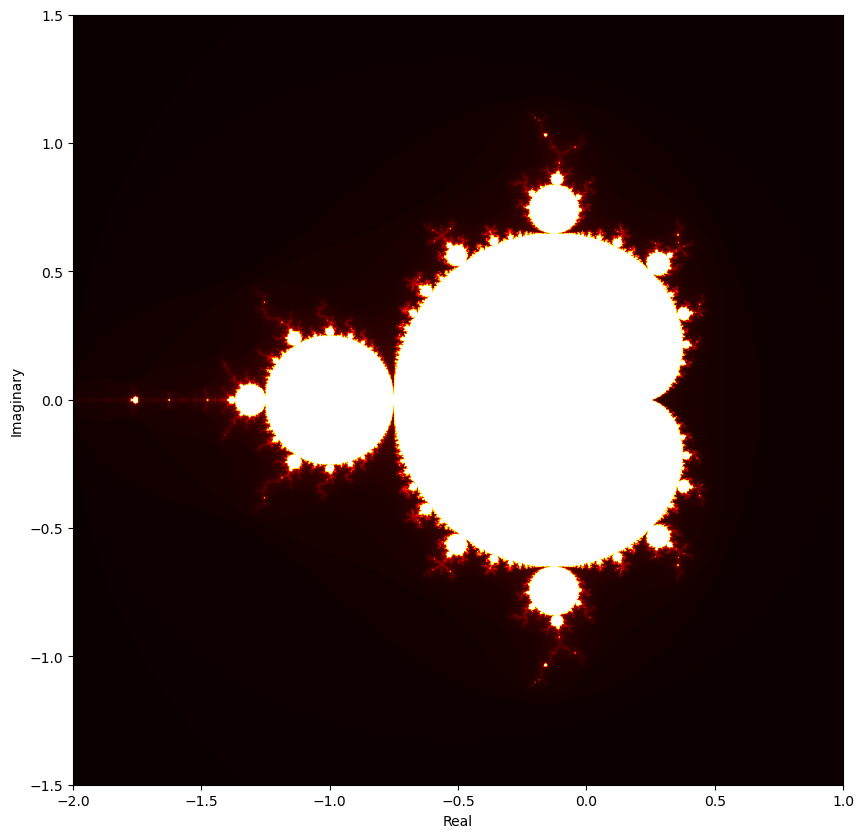

In [195]:
# Visualize with interpolation
plt.figure(figsize=(10, 10))
plt.imshow(image.T, cmap='hot', interpolation='bilinear', extent=[-2, 1, -1.5, 1.5])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()

In [196]:
from scipy.interpolate import pchip_interpolate
from matplotlib.colors import LinearSegmentedColormap

def custom_colourmap():
    #set up the control points for your gradient
    yR_observed = [0, 0,32,237, 255, 0, 0, 32]
    yG_observed = [2, 7, 107, 255, 170, 2, 7, 107]
    yB_observed = [0, 100, 203, 255, 0, 0, 100, 203]

    x_observed = [-.1425, 0, .16, .42, .6425, .8575, 1, 1.16]

    #Create the arrays with the interpolated values
    x = np.linspace(min(x_observed), max(x_observed), num=1000)
    yR = pchip_interpolate(x_observed, yR_observed, x)
    yG = pchip_interpolate(x_observed, yG_observed, x)
    yB = pchip_interpolate(x_observed, yB_observed, x)

    #Convert them back to python lists
    x = list(x)
    yR = list(yR)
    yG = list(yG)
    yB = list(yB)

    #Find the indexs where x crosses 0 and crosses 1 for slicing
    start = 0
    end = 0
    for i in x:
        if i > 0:
            start = x.index(i)
            break

    for i in x:
        if i > 1:
            end = x.index(i)
            break

    #Slice away the helper data in the begining and end leaving just 0 to 1
    x = x[start:end]
    yR = yR[start:end]
    yG = yG[start:end]
    yB = yB[start:end]

    # Normalize the color values to the [0, 1] range
    yR = np.array(yR) / 255.0
    yG = np.array(yG) / 255.0
    yB = np.array(yB) / 255.0

    # Append 0 to the end of yR, yG, and yB
    yR = np.append(yR, 0.0)
    yG = np.append(yG, 0.0)
    yB = np.append(yB, 0.0)

    # Create a custom colormap from the interpolated color values
    colors = np.column_stack((yR, yG, yB))  # Combine R, G, and B values
    cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)
    
    return cmap


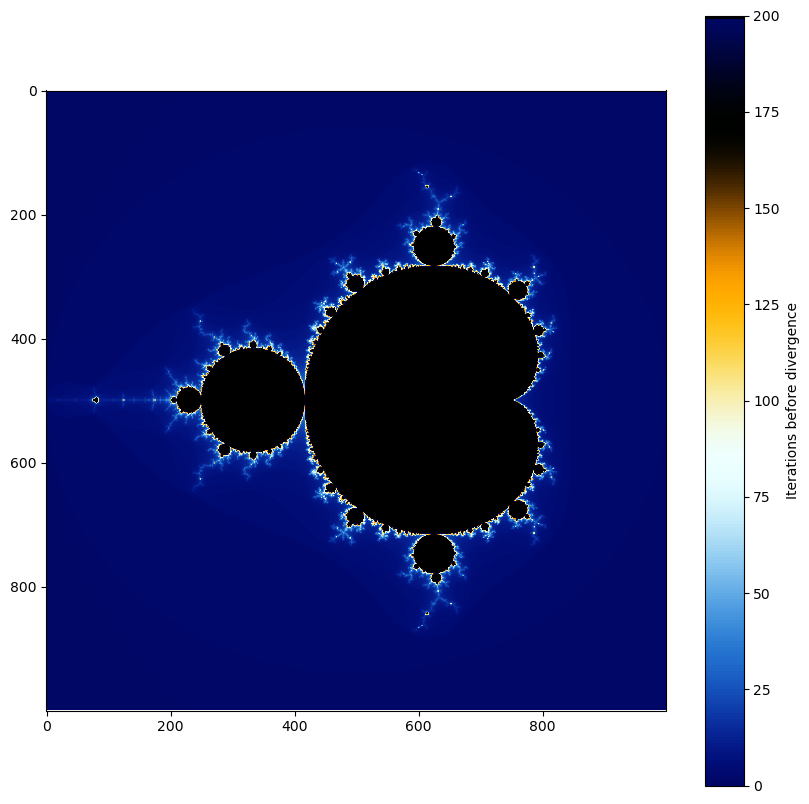

In [197]:
cmap = custom_colourmap()

# Create a figure and plot the data using the custom colormap
plt.figure(figsize=(10, 10))
plt.imshow(image.T, cmap=cmap)
plt.colorbar().set_label('Iterations before divergence')
plt.show()

## Question 2

Analyze how $i$ influence $A_{is}$ when $s$ is 100000(very large).

In [7]:
# Define the pure random sampling function
def pure_random_sampling(num_samples, real_range, imag_range):
    real_samples = np.random.uniform(real_range[0], real_range[1], num_samples)
    imag_samples = np.random.uniform(imag_range[0], imag_range[1], num_samples)
    return real_samples + 1j * imag_samples

# Define a function to estimate the area of the Mandelbrot set using sampling
def estimate_area(samples, max_iter):
    inside_count = 0
    for c in samples:
        if stability(c, max_iter) == max_iter:
            inside_count += 1
    area = 9 * inside_count / len(samples)
    return area

# Define a function to calculate the convergence of areas for different values of max_iter
def convergence_curve(samples, max_iter_range):
    areas = []
    times = []
    
    for max_iter in max_iter_range:
        start_time = time()
        area = estimate_area(samples, max_iter)
        times.append(time() - start_time)
        areas.append(area)
    
    return areas, times

In [8]:
# Set parameters for the area estimation
num_samples = 100000
max_iter_range_adjusted = np.arange(100, 6000, 100)
real_range = [-2, 1]
imag_range = [-1.5, 1.5]

# Run the pure random sampling once and store the samples
pure_random_samples = pure_random_sampling(num_samples, real_range, imag_range)

# Calculate the convergence curve for pure random sampling with adjusted range
areas_pure_random, times_pure_random = convergence_curve(
    pure_random_samples,
    max_iter_range_adjusted
)


### Find the smallest i that meets the desired_relative_error(0.1%)

In [200]:
# Initialize variables to store the minimum i that meets the condition
# and the corresponding relative error
min_i = None
min_i_relative_error = None
Af = areas_pure_random[-1]
desired_relative_error = 0.001
# Track whether the desired relative error condition has been met
condition_met = False

# Find the minimum i that satisfies the desired relative error
# and ensure that all larger i values also have a relative error less than the threshold
for i, area in enumerate(areas_pure_random):
    relative_error = abs(area - Af) / Af
    
    # Check if the current relative error meets the desired condition
    if relative_error <= desired_relative_error:
        if not condition_met:  # Condition met for the first time
            min_i = max_iter_range_adjusted[i]
            min_i_relative_error = relative_error
            min_i_index = i
            condition_met = True
        else:
            # Check if any subsequent i has a relative error greater than the threshold
            if relative_error > desired_relative_error:
                # If a larger i has a higher relative error, reset the condition
                condition_met = False
                min_i = None
                min_i_relative_error = None
                min_i_index = 9999

# Output results
  # Assume the last area is the final area Af
if min_i is not None:
    print(f"The minimum i that satisfies the desired relative error of {desired_relative_error*100}% is {min_i}.")
    print(f"The relative error achieved is {min_i_relative_error*100}%.")  
    print(f"The area at this i is {areas_pure_random[min_i_index]}.")
else:
    print("No minimum i found that satisfies the relative error condition for all subsequent i values.")

print(f"$A_f$ is {Af}")


The minimum i that satisfies the desired relative error of 0.1% is 2300.
The relative error achieved is 0.09575677778441995%.
The area at this i is 1.50525.
$A_f$ is 1.50381


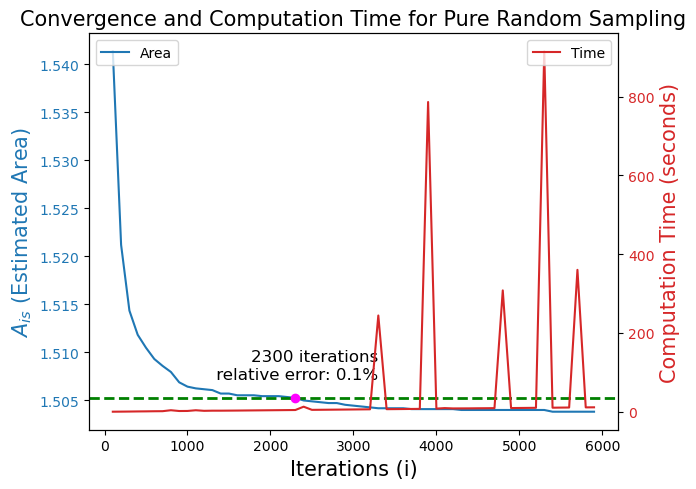

In [201]:
# Plotting
fig, ax1 = plt.subplots(figsize=(7, 5))

color = 'tab:blue'
ax1.set_xlabel('Iterations (i)', fontsize=15)
ax1.set_ylabel(r'$A_{is}$ (Estimated Area)', color=color, fontsize=15)
ax1.plot(max_iter_range_adjusted, areas_pure_random, label='Area', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Computation Time (seconds)', color=color, fontsize=15)
ax2.plot(max_iter_range_adjusted, times_pure_random, label='Time', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Convergence and Computation Time for Pure Random Sampling', fontsize = 15)

# Add a horizontal line to indicate the minimum number of iterations to satisfy the desired relative error
ax1.axhline(y=areas_pure_random[min_i_index], color='green', linestyle='--', linewidth=2)

# Annotate the minimum number of iterations and relative error
relative_error_percent = min_i_relative_error * 100
# Add a magenta point to mark the minimum i
ax1.scatter(min_i, areas_pure_random[min_i_index], color='magenta', zorder=5)
# Add text annotation next to the point
ax1.annotate(f'{min_i} iterations\n relative error: {relative_error_percent:.1f}%', 
             xy=(min_i, areas_pure_random[min_i_index]), 
             xytext=(min_i + 1000, areas_pure_random[min_i_index] + 0.002), # slight offset for readability
             fontsize=12,
             horizontalalignment='right')
plt.tight_layout()

plt.savefig("2.1 Smallest i.jpg", dpi=300)
plt.show()


### Upon different s
Since we are not going to sample more than 20000 points in Q2 and Q3, below we choose num_samples = [10000, 20000, 100000] to see if the min_i we find using the same method as above will have big differences.

The reason why we choose bigger s is because we want to control the influence of sampling stochasticity. Bigger s means higher chances to sample points that are hard to determine whether it is in or out of the Mandelbrot Set.

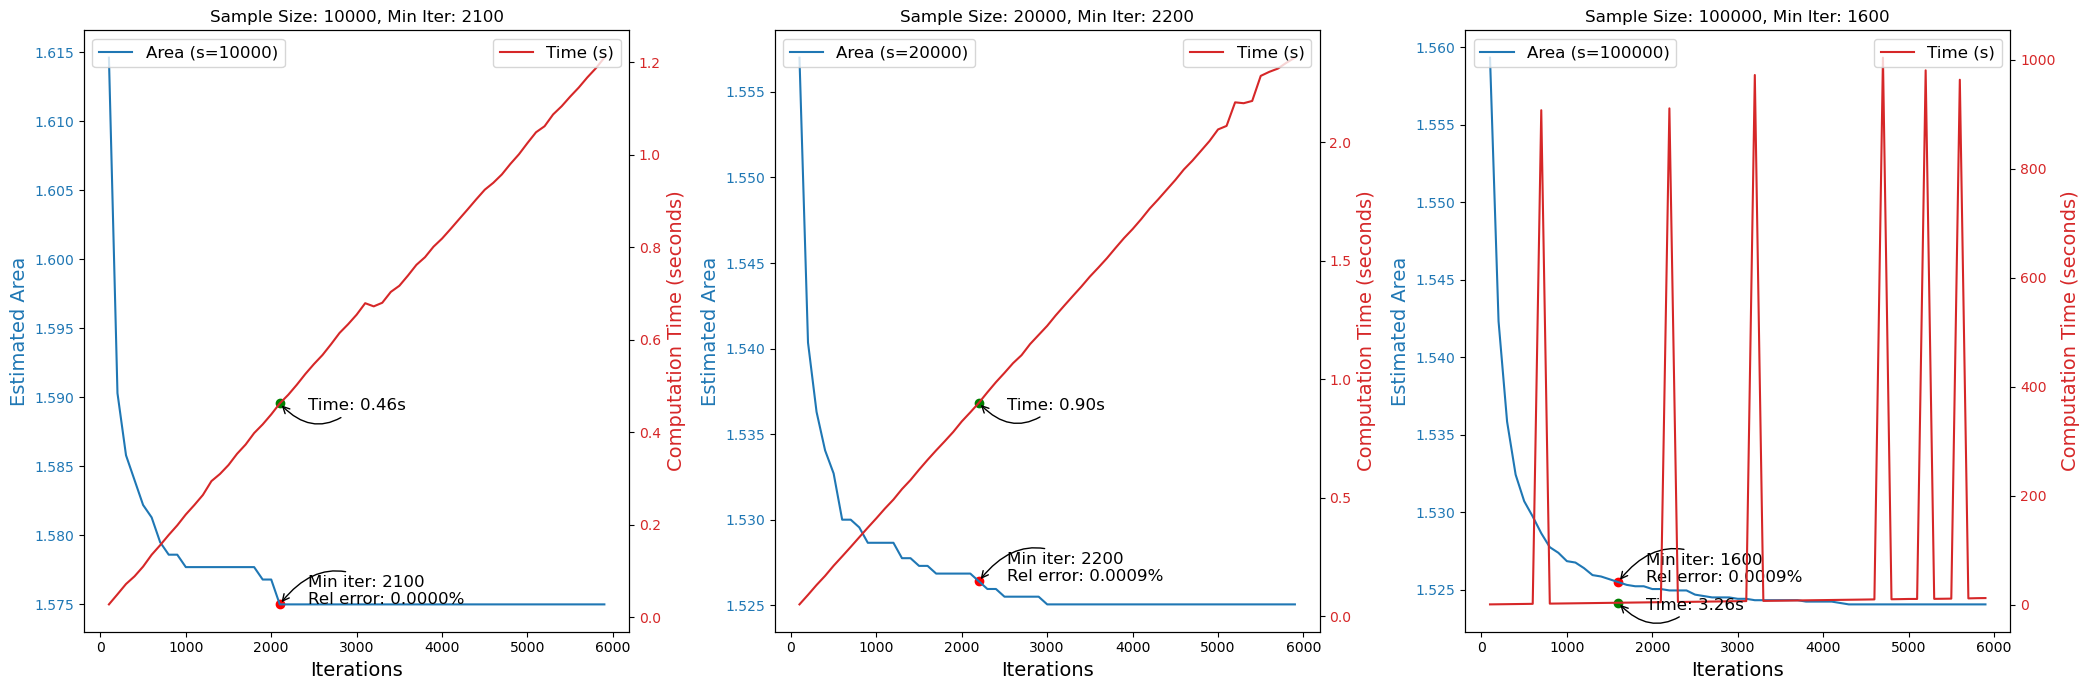

In [202]:
def find_min_iterations(areas, desired_rel_error, iter_range, Af):
    for i, area in enumerate(areas):
        relative_error = abs(area - Af) / Af
        if relative_error <= desired_rel_error:
            return iter_range[i], relative_error, i
    return None, None, None

def convergence_analysis_and_plotting(sample_size, max_iter_range, real_range, imag_range, desired_rel_error, ax):
    samples = pure_random_sampling(sample_size, real_range, imag_range)
    areas, times = convergence_curve(samples, max_iter_range)

    # Plot area convergence
    ax1 = ax
    ax1.plot(max_iter_range, areas, label=f'Area (s={sample_size})', color='tab:blue')
    ax1.set_xlabel('Iterations', fontsize = 14)
    ax1.set_ylabel('Estimated Area', color='tab:blue', fontsize = 14)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='upper left', fontsize = 12)

    # Plot computation time
    ax2 = ax1.twinx()  
    ax2.plot(max_iter_range, times, label='Time (s)', color='tab:red')
    ax2.set_ylabel('Computation Time (seconds)', color='tab:red', fontsize = 14)
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.legend(loc='upper right', fontsize = 12)

    # Find and annotate the minimum iteration point
    Af = areas[-1]  # Final area estimate
    min_i, min_i_relative_error, min_i_index = find_min_iterations(areas, desired_rel_error, max_iter_range, Af)
    if min_i is not None:
        ax1.scatter(min_i, areas[min_i_index], color='red')
        ax1.annotate(f'Min iter: {min_i}\nRel error: {min_i_relative_error:.4f}%',
                    xy=(min_i, areas[min_i_index]), xytext=(20, 0), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.5'), fontsize = 12)
        ax2.scatter(min_i, times[min_i_index], color='green')
        ax2.annotate(f'Time: {times[min_i_index]:.2f}s',
                    xy=(min_i, times[min_i_index]), xytext=(20, -5), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-.5'), fontsize = 12)

    return min_i, min_i_relative_error

real_range = [-2, 1]
imag_range = [-1.5, 1.5]
sample_sizes = [10000, 20000, 100000]
max_iter_range = np.arange(100, 6000, 100)
desired_relative_error = 0.001

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
for i, sample_size in enumerate(sample_sizes):
    min_i, min_i_rel_error = convergence_analysis_and_plotting(
        sample_size, max_iter_range, real_range, imag_range,
        desired_relative_error, axes[i]
    )
    axes[i].set_title(f'Sample Size: {sample_size}, Min Iter: {min_i}')

plt.tight_layout()
plt.savefig("2.10 Convergence_Analysis.jpg", dpi=300)
plt.show()

### Find mean for min_i when s = 100000

In [204]:
# Parameters for the area estimation
num_samples = 100000
max_iter_range_adjusted = np.arange(100, 6000, 100)
real_range = [-2, 1]
imag_range = [-1.5, 1.5]


# Run 10 times and calculate min iterations
min_iterations_results = []
for _ in range(10):
    pure_random_samples = pure_random_sampling(num_samples, real_range, imag_range)
    areas_pure_random, times_pure_random = convergence_curve(pure_random_samples, max_iter_range_adjusted)
    Af = areas_pure_random[-1]
    min_i, _, _ = find_min_iterations(areas_pure_random, 0.001, max_iter_range_adjusted, Af)
    min_iterations_results.append(min_i)
    print(f"Min iterations for run: {min_i}")

# Calculate the average of the minimum iterations
average_min_iterations = np.mean(min_iterations_results)
print(average_min_iterations)
max_iter = average_min_iterations

Min iterations for run: 1500
Min iterations for run: 1900
Min iterations for run: 1500
Min iterations for run: 1400
Min iterations for run: 1800
Min iterations for run: 1900
Min iterations for run: 1600
Min iterations for run: 1800
Min iterations for run: 1600
Min iterations for run: 1600
1660.0


### Confidence Interval Analysis using CLT on i
We try to use CLT on different i to see if the Ais will converge when i increases.

In [ ]:
# Define the function to encapsulate the confidence interval calculation
def calculate_confidence_intervals_for_i(sampling_method, sample_sizes, real_range, imag_range, n, iterations):
    conf_interval_radii = []
    mean_areas = []
    times = [] # stores the time each s used to calculate the confidence intervals and sample mean values
    
    # Perform the area estimation for each sample size
    for i in iterations:
        start_time = time()  # start time
        area_estimates = []
        samples = sampling_method(sample_sizes, real_range, imag_range)

        for _ in range(n):
            area = estimate_area(samples, i)
            area_estimates.append(area)

        # Calculate the mean and standard deviation of the area estimates
        mean_area_estimated = np.mean(area_estimates)
        mean_areas.append(mean_area_estimated)
        std_area_estimated = np.std(area_estimates, ddof=1)

        # Calculate the 99% confidence interval radius
        z_score = norm.ppf(0.995)
        conf_radius = z_score * (std_area_estimated / np.sqrt(n))
        conf_interval_radii.append(conf_radius)

        end_time = time()  # end time
        times.append(end_time - start_time)  # compute the time

    return np.array(conf_interval_radii), np.array(mean_areas), np.array(times)

In [ ]:
# Example usage
sample_sizes = 10000
n = 50  # number of times to sample for each sample size
iterations = np.arange(100,5000,100)

# Calculate confidence intervals for pure random sampling
conf_intervals_pure_random, mean_areas_random, times_pure_random = calculate_confidence_intervals_for_i(
    pure_random_sampling, sample_sizes, real_range, imag_range, n, iterations
)

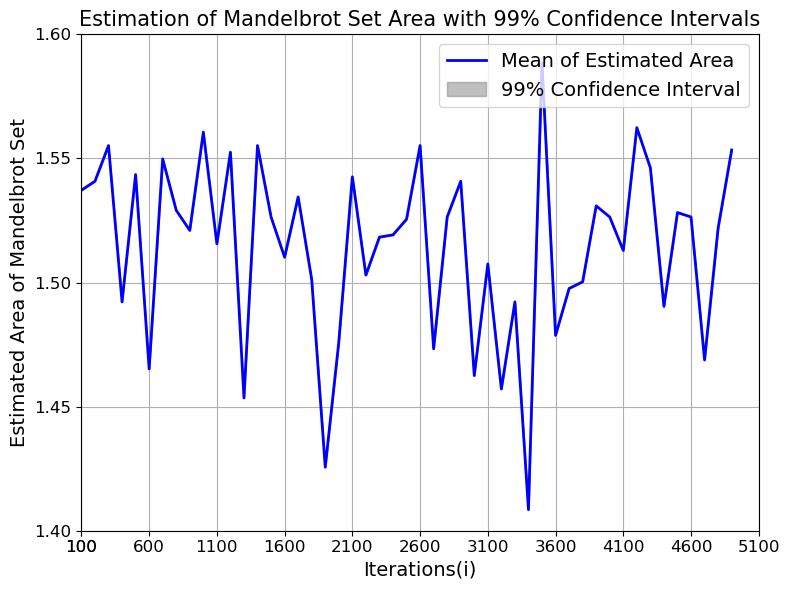

In [ ]:
# Plot the estimated area and confidence intervals
plt.figure(figsize=(8, 6))
plt.plot(iterations, mean_areas_random, label='Mean of Estimated Area', color='blue', linewidth=2)
plt.fill_between(iterations, mean_areas_random - conf_intervals_pure_random, 
                 mean_areas_random + conf_intervals_pure_random, color='gray', alpha=0.5, 
                 label='99% Confidence Interval')

# Set chart title and labels with specified font sizes
plt.title('Estimation of Mandelbrot Set Area with 99% Confidence Intervals', fontsize=15)
plt.xlabel('Iterations(i)', fontsize=14)
plt.ylabel('Estimated Area of Mandelbrot Set', fontsize=14)

# Specify font sizes for legend and grid
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)

# Set the x and y axis limits to ensure the origin is shown
plt.xlim(left=iterations[0], right=iterations[-1])
plt.ylim(bottom=min(mean_areas_random - conf_intervals_pure_random), top=max(mean_areas_random + conf_intervals_pure_random))

# Customize the tick marks font size and set specific ticks on x-axis
ax = plt.gca()  # Get the current Axes instance
ax.set_xticks([iterations[0]] + list(range(100, iterations[-1]+500, 500)))  # Set specific x-ticks
ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], num=5))  # Set y-ticks to be less dense

# Customize the tick labels font size
ax.tick_params(axis='x', labelsize=12)  # Smaller font size for x-ticks
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig("2.8 mean value and confidence intervals for i.jpg", dpi=300)
plt.show()

/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/11700943.py:63: UserWarning: The label '_child1' of <matplotlib.lines.Line2D object at 0x16aea5b10> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize=14)
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/11700943.py:63: UserWarning: The label '_child2' of <matplotlib.lines.Line2D object at 0x16ac08c90> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize=14)
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/11700943.py:63: UserWarning: The label '_child4' of <matplotlib.lines.Line2D object at 0x16ad665d0> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize=14)
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/11700943.py:63: UserWarning: The label '_child1' of <matplotlib.lines.Line2D object at 0x16a8b4a50> starts with '_'. It is thus excluded from the legend.
 

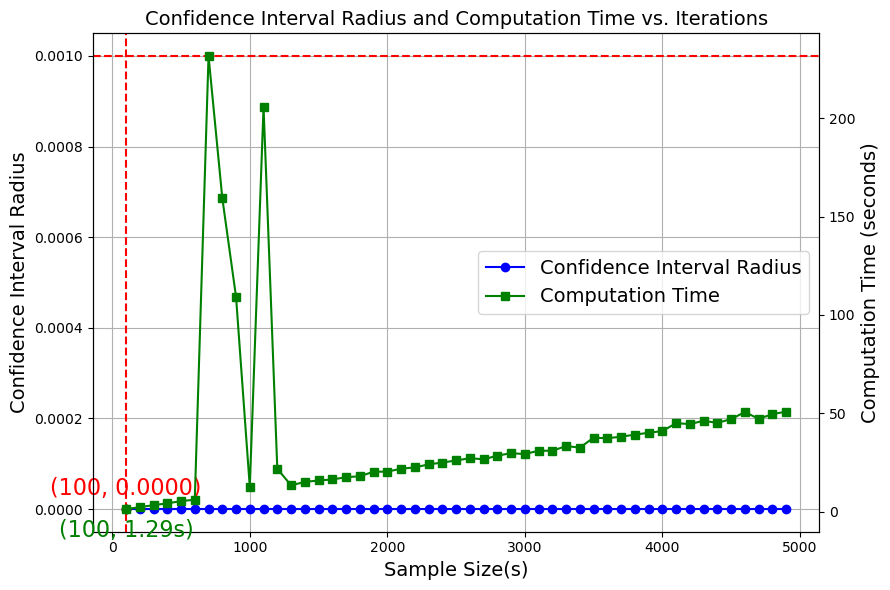

In [ ]:
def mark_min_confidence_interval_time_for_i(ax, ax2, iterations, conf_intervals, times, threshold=0.001, notationcolorx='r', notationcolory='g'):
    valid_indices = np.where(conf_intervals < threshold)[0]
    if valid_indices.size == 0:
        print("No sample size meets the criterion.")
        return

    # Find the first index that satisfies the condition and ensure that all subsequent sample sizes also satisfy the condition
    for idx in valid_indices:
        if all(conf_intervals[idx:] < threshold):
            min_i_index = idx
            break
    else:
        print("No consecutive sample sizes meet the criterion.")
        return

    min_i = iterations[min_i_index]
    min_conf_interval = conf_intervals[min_i_index]
    min_time = times[min_i_index]

    ax.plot(min_i, min_conf_interval, notationcolorx+'o')  # Mark with circle
    ax.annotate(f'({min_i}, {min_conf_interval:.4f})', 
                 (min_i, min_conf_interval), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 fontsize=16,
                 ha='center',
                 color=notationcolorx)
    # Draw a vertical dashed line at the minimum sample size
    ax.axvline(x=min_i, color=notationcolorx, linestyle='--')

    # Mark the computation time at the minimum sample size
    ax2.plot(min_i, min_time, notationcolory+'o')  # Mark with circle
    ax2.annotate(f'({min_i}, {min_time:.2f}s)', 
                (min_i, min_time), 
                textcoords="offset points", 
                xytext=(0,-20), 
                fontsize=16,
                ha='center',
                color=notationcolory)

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(9, 6))
threshold = 0.001

# Plot the confidence interval on ax1
ax1.plot(iterations, conf_intervals_pure_random, marker='o', label='Confidence Interval Radius', color='blue')
ax1.axhline(y=threshold, color='red', linestyle='--')
ax1.set_xlabel('Sample Size(s)', fontsize=14)
ax1.set_ylabel('Confidence Interval Radius', fontsize=14)
ax1.set_title('Confidence Interval Radius and Computation Time vs. Iterations', fontsize=14)

# Use another y-axis for the computation time
ax2 = ax1.twinx()  
ax2.plot(iterations, times_pure_random, marker='s', label='Computation Time', color='green')
ax2.set_ylabel('Computation Time (seconds)', fontsize=14)

# Mark the minimum confidence interval that meets the threshold
mark_min_confidence_interval_time_for_i(ax1, ax2, iterations, conf_intervals_pure_random, times_pure_random)

# Handle legends for both axes
lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize=14)

ax1.grid(True)
plt.tight_layout()
plt.savefig("2.4 confidence_interval_and_time_combined_for_i.jpg", dpi=300)
plt.show()

The result is not significant.

### Use i = min_iter to plot Ais and relative error upon different s
This i varies. Above is 2300, but for different runs, we can get different min_i.

In [208]:
# Define the parameters for the area estimation
num_samples_start = 1000
num_samples_max = 100000
desired_d = 0.001
real_range = [-2, 1]
imag_range = [-1.5, 1.5]
max_iter = int(average_min_iterations)

# Initialize variables for the iterative process
num_samples = num_samples_start
Am_estimations = []
relative_errors = []
sample_sizes = []

# Main iterative process
while num_samples <= num_samples_max:
    # Generate samples and estimate area
    samples = pure_random_sampling(num_samples, real_range, imag_range)
    current_area = estimate_area(samples, max_iter)
    
    # Assume Am is the area estimated with the maximum number of samples
    if num_samples == num_samples_max:
        Am = current_area
    
    # Calculate relative error
    relative_error = abs(Am - current_area) / Am
    relative_errors.append(relative_error)
    Am_estimations.append(current_area)
    sample_sizes.append(num_samples)
    
    print(f"Number of samples: {num_samples}, Estimated Area: {current_area}, Relative Error: {relative_error}")
    
    # Update num_samples for next iteration
    num_samples += 1000

Number of samples: 1000, Estimated Area: 1.512, Relative Error: 0.0016097299230906365
Number of samples: 2000, Estimated Area: 1.575, Relative Error: 0.043343468669886046
Number of samples: 3000, Estimated Area: 1.497, Relative Error: 0.008326874540432024
Number of samples: 4000, Estimated Area: 1.54125, Relative Error: 0.02098610862695995
Number of samples: 5000, Estimated Area: 1.53, Relative Error: 0.013533655279317916
Number of samples: 6000, Estimated Area: 1.4655, Relative Error: 0.0291937439138298
Number of samples: 7000, Estimated Area: 1.467, Relative Error: 0.02820008346747749
Number of samples: 8000, Estimated Area: 1.549125, Relative Error: 0.02620282597030943
Number of samples: 9000, Estimated Area: 1.54, Relative Error: 0.02015805825499974
Number of samples: 10000, Estimated Area: 1.4877, Relative Error: 0.014487569307816169
Number of samples: 11000, Estimated Area: 1.476, Relative Error: 0.022238120789363925
Number of samples: 12000, Estimated Area: 1.47375, Relative Err

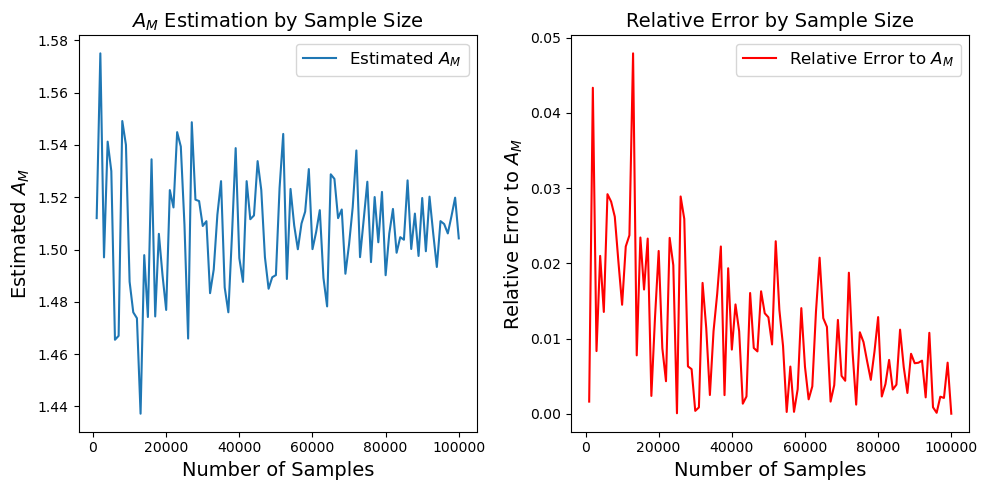

In [209]:
# Plotting the results
plt.figure(figsize=(10, 5))

# Plot Am estimations
plt.subplot(1, 2, 1)
plt.plot(sample_sizes, Am_estimations, label=r'Estimated $A_M$')
plt.xlabel('Number of Samples', fontsize=14)
plt.ylabel(r'Estimated $A_M$', fontsize=14)
plt.title(r'$A_M$ Estimation by Sample Size', fontsize=14)
plt.legend(fontsize = 12)



# Plot relative errors
plt.subplot(1, 2, 2)
plt.plot(sample_sizes, relative_errors, label=r'Relative Error to $A_M$', color='red')
plt.xlabel('Number of Samples',  fontsize=14)
plt.ylabel(r'Relative Error to $A_M$', fontsize=14)
plt.title('Relative Error by Sample Size', fontsize=14)
plt.legend(fontsize = 12)

plt.tight_layout()
plt.savefig("2.2 different s.jpg", dpi = 300)
plt.show()


Too much stochasticity.

### Find s using confidence interval(significance level = 99%)
For each s, we run n times(n>30) and we apply CLT to calculate how certain We are the $A_M$ will fall within the confidence interval.


In [3]:
# Define the function to encapsulate the confidence interval calculation
def calculate_confidence_intervals(sampling_method, sample_sizes, real_range, imag_range, n, max_iter):
    conf_interval_radii = []
    mean_areas = []
    times = [] # stores the time each s used to calculate the confidence intervals and sample mean values
    
    # Perform the area estimation for each sample size
    for s in sample_sizes:
        start_time = time()  # start time
        area_estimates = []

        for _ in range(n):
            samples = sampling_method(s, real_range, imag_range)
            area = estimate_area(samples, max_iter)
            area_estimates.append(area)

        # Calculate the mean and standard deviation of the area estimates
        mean_area_estimated = np.mean(area_estimates)
        mean_areas.append(mean_area_estimated)
        std_area_estimated = np.std(area_estimates, ddof=1)

        # Calculate the 99% confidence interval radius
        z_score = norm.ppf(0.995)
        conf_radius = z_score * (std_area_estimated / np.sqrt(n))
        conf_interval_radii.append(conf_radius)

        end_time = time()  # end time
        times.append(end_time - start_time)  # compute the time

    return np.array(conf_interval_radii), np.array(mean_areas), np.array(times)


In [215]:
# Example usage
sample_sizes = np.arange(1000, 25000, 1000)
n = 50  # number of times to sample for each sample size

# Calculate confidence intervals for pure random sampling
conf_intervals_pure_random, mean_areas_random, times_pure_random = calculate_confidence_intervals(
    pure_random_sampling, sample_sizes, real_range, imag_range, n, max_iter
)

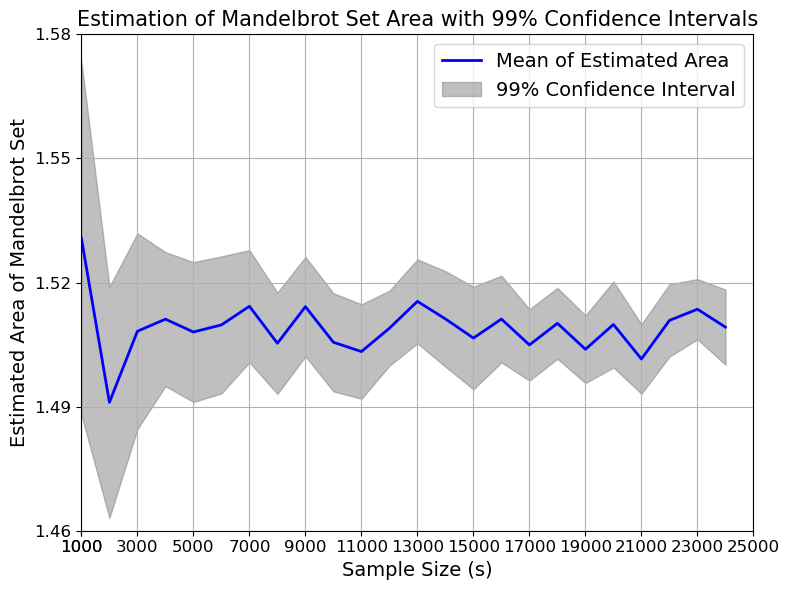

In [216]:
# Plot the estimated area and confidence intervals
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, mean_areas_random, label='Mean of Estimated Area', color='blue', linewidth=2)
plt.fill_between(sample_sizes, mean_areas_random - conf_intervals_pure_random, 
                 mean_areas_random + conf_intervals_pure_random, color='gray', alpha=0.5, 
                 label='99% Confidence Interval')

# Set chart title and labels with specified font sizes
plt.title('Estimation of Mandelbrot Set Area with 99% Confidence Intervals', fontsize=15)
plt.xlabel('Sample Size (s)', fontsize=14)
plt.ylabel('Estimated Area of Mandelbrot Set', fontsize=14)

# Specify font sizes for legend and grid
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)

# Set the x and y axis limits to ensure the origin is shown
plt.xlim(left=sample_sizes[0], right=sample_sizes[-1])
plt.ylim(bottom=min(mean_areas_random - conf_intervals_pure_random), top=max(mean_areas_random + conf_intervals_pure_random))

# Customize the tick marks font size and set specific ticks on x-axis
ax = plt.gca()  # Get the current Axes instance
ax.set_xticks([sample_sizes[0]] + list(range(1000, sample_sizes[-1]+2000, 2000)))  # Set specific x-ticks
ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], num=5))  # Set y-ticks to be less dense

# Customize the tick labels font size
ax.tick_params(axis='x', labelsize=12)  # Smaller font size for x-ticks
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig("2.3 mean value and confidence intervals.jpg", dpi=300)
plt.show()

/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/2025483301.py:63: UserWarning: The label '_child1' of <matplotlib.lines.Line2D object at 0x16ad1a7d0> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize=14)
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/2025483301.py:63: UserWarning: The label '_child2' of <matplotlib.lines.Line2D object at 0x16acf8d10> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize=14)
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/2025483301.py:63: UserWarning: The label '_child4' of <matplotlib.lines.Line2D object at 0x16abb0390> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize=14)
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/2025483301.py:63: UserWarning: The label '_child1' of <matplotlib.lines.Line2D object at 0x16a9928d0> starts with '_'. It is thus excluded from the l

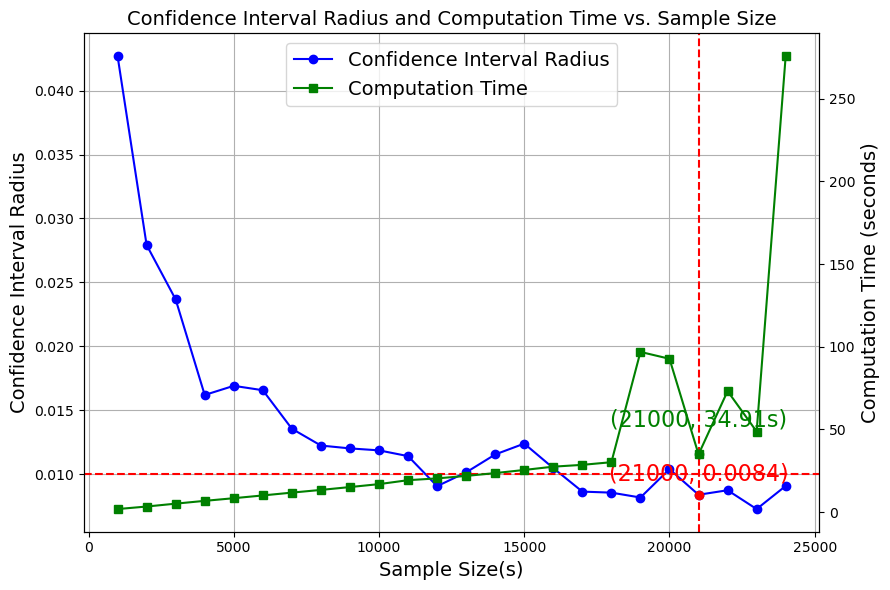

In [221]:
def mark_min_confidence_interval_time(ax, ax2, sample_sizes, conf_intervals, times, threshold, notationcolorx='r', notationcolory='g'):
    valid_indices = np.where(conf_intervals < threshold)[0]
    if valid_indices.size == 0:
        print("No sample size meets the criterion.")
        return

    # Find the first index that satisfies the condition and ensure that all subsequent sample sizes also satisfy the condition
    for idx in valid_indices:
        if all(conf_intervals[idx:] < threshold):
            min_s_index = idx
            break
    else:
        print("No consecutive sample sizes meet the criterion.")
        return

    min_s = sample_sizes[min_s_index]
    min_conf_interval = conf_intervals[min_s_index]
    min_time = times[min_s_index]

    ax.plot(min_s, min_conf_interval, notationcolorx+'o')  # Mark with circle
    ax.annotate(f'({min_s}, {min_conf_interval:.4f})', 
                 (min_s, min_conf_interval), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 fontsize=16,
                 ha='center',
                 color=notationcolorx)
    # Draw a vertical dashed line at the minimum sample size
    ax.axvline(x=min_s, color=notationcolorx, linestyle='--')

    # Mark the computation time at the minimum sample size
    ax2.plot(min_s, min_time, notationcolory+'o')  # Mark with circle
    ax2.annotate(f'({min_s}, {min_time:.2f}s)', 
                (min_s, min_time), 
                textcoords="offset points", 
                xytext=(0,20), 
                fontsize=16,
                ha='center',
                color=notationcolory)

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(9, 6))
threshold = 0.01

# Plot the confidence interval on ax1
ax1.plot(sample_sizes, conf_intervals_pure_random, marker='o', label='Confidence Interval Radius', color='blue')
ax1.axhline(y=threshold, color='red', linestyle='--')
ax1.set_xlabel('Sample Size(s)', fontsize=14)
ax1.set_ylabel('Confidence Interval Radius', fontsize=14)
ax1.set_title('Confidence Interval Radius and Computation Time vs. Sample Size', fontsize=14)

# Use another y-axis for the computation time
ax2 = ax1.twinx()  
ax2.plot(sample_sizes, times_pure_random, marker='s', label='Computation Time', color='green')
ax2.set_ylabel('Computation Time (seconds)', fontsize=14)

# Mark the minimum confidence interval that meets the threshold
mark_min_confidence_interval_time(ax1, ax2, sample_sizes, conf_intervals_pure_random, times_pure_random, threshold)

# Handle legends for both axes
lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize=14)

ax1.grid(True)
plt.tight_layout()
plt.savefig("2.4 confidence_interval_and_time_combined.jpg", dpi=300)
plt.show()


Make n = [30,50,100]

In [329]:
sample_sizes = np.arange(1000, 20001, 1000)
n_values = [30, 50, 100]
real_range = (-2, 1)
imag_range = (-1.5, 1.5)

# Pre-calculate confidence intervals and mean areas for different values of n
results_dict = {}

for n_val in n_values:
    conf_intervals, mean_areas, times = calculate_confidence_intervals(
        pure_random_sampling, sample_sizes, real_range, imag_range, n_val, max_iter
    )
    results_dict[n_val] = {
        'conf_intervals': conf_intervals,
        'mean_areas': mean_areas,
        'times': times
    }

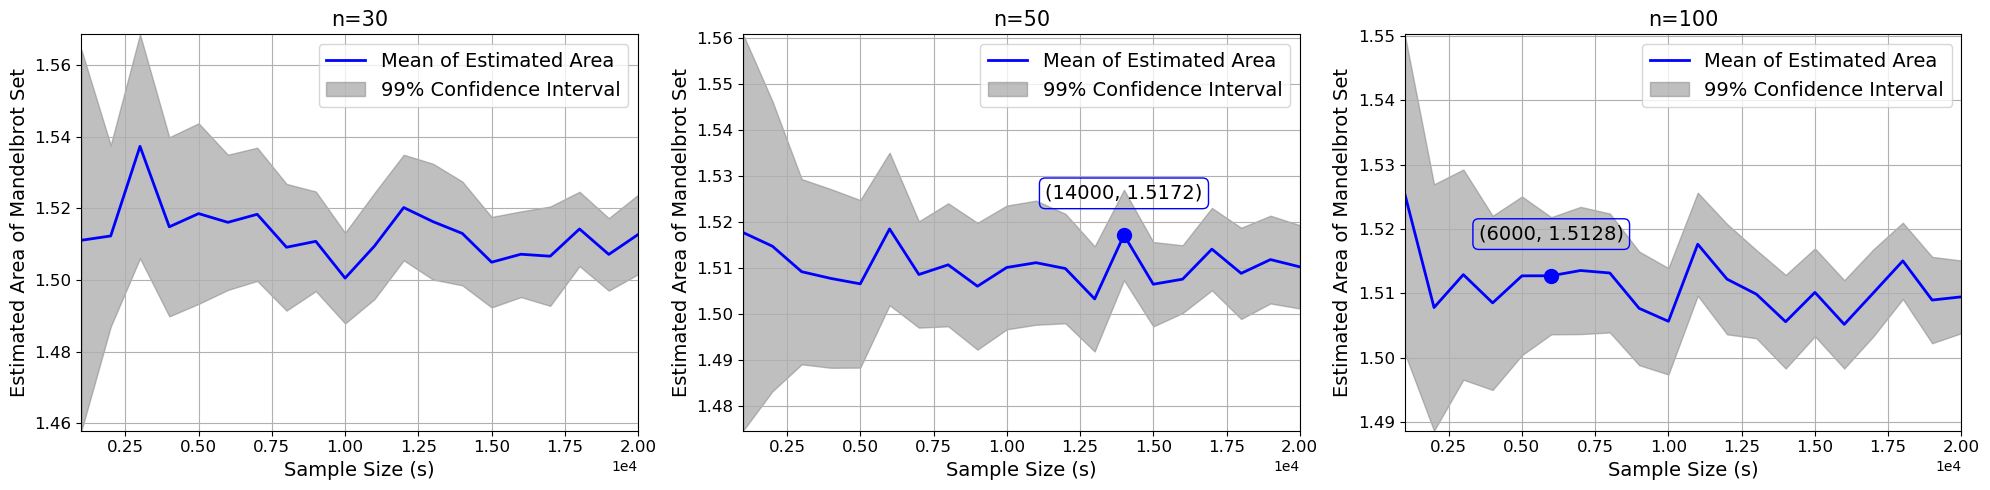

In [337]:
# Define the function to find the minimum sample size where the confidence interval is below the threshold
def find_min_confidence_interval_mean(sample_sizes, conf_intervals, mean_areas, threshold=0.001):
    valid_indices = np.where(conf_intervals < threshold)[0]
    if valid_indices.size == 0:
        return None, None  # Return None if no valid index found
    # Find the first occurrence where all subsequent conf_intervals are below the threshold
    for idx in valid_indices:
        if all(conf_intervals[idx:] < threshold):
            return sample_sizes[idx], mean_areas[idx]
    return None, None

# Define the function to mark the points on the plot
def mark_point(ax, x, y, color='r', text_offset=(0, 0)):
    ax.plot(x, y, 'o', color=color, markersize=10)
    ax.annotate(f'({x}, {y:.4f})', 
                xy=(x, y), 
                xytext=text_offset,
                textcoords="offset points",
                fontsize=14,
                ha='center',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='none'))
    
# Setting up the plot for 1x3 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# We'll store the axis objects in a dictionary for easy access
axes_dict = {n: ax for n, ax in zip(n_values, axs)}

# Define thresholds
thresholds = 0.01

# Plot for different values of n using the pre-calculated results
for n_val, ax in axes_dict.items():
    # Retrieve pre-calculated data
    conf_intervals = results_dict[n_val]['conf_intervals']
    mean_areas = results_dict[n_val]['mean_areas']
    times = results_dict[n_val]['times']  # not used in plotting

    ax.plot(sample_sizes, mean_areas, label='Mean of Estimated Area', color='blue', linewidth=2)
    ax.fill_between(sample_sizes, mean_areas - conf_intervals, 
                    mean_areas + conf_intervals, color='gray', alpha=0.5, 
                    label='99% Confidence Interval')

    # Plot the confidence intervals and annotate the mean for each sampling method
   
    min_s, min_mean = find_min_confidence_interval_mean(sample_sizes, conf_intervals, mean_areas, threshold)
        
    # Check if the points were found and then annotate them on the plot
    if min_s is not None:
        threshold_label = f'Threshold {threshold}'
        mark_point(ax, min_s, min_mean, color='blue', text_offset=(0, 30))

    # Set chart title and labels with specified font sizes
    ax.set_title(f'n={n_val}', fontsize=15)
    ax.set_xlabel('Sample Size (s)', fontsize=14)
    ax.set_ylabel('Estimated Area of Mandelbrot Set', fontsize=14)

    # Specify font sizes for legend and grid
    ax.legend(loc='upper right', fontsize=14)
    ax.grid(True)

    # Set the x and y axis limits
    ax.set_xlim(left=sample_sizes[0], right=sample_sizes[-1])
    ax.set_ylim(bottom=np.min(mean_areas - conf_intervals), top=np.max(mean_areas + conf_intervals))

    # Set the x-axis to use a scientific notation
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    # Customize the tick labels font size
    ax.tick_params(axis='x', labelsize=12)  # Smaller font size for x-ticks
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig("2.9_mean_value_and_confidence_intervals_1x4_sci_separated.jpg", dpi=300)
plt.show()

No sample size meets the criterion.


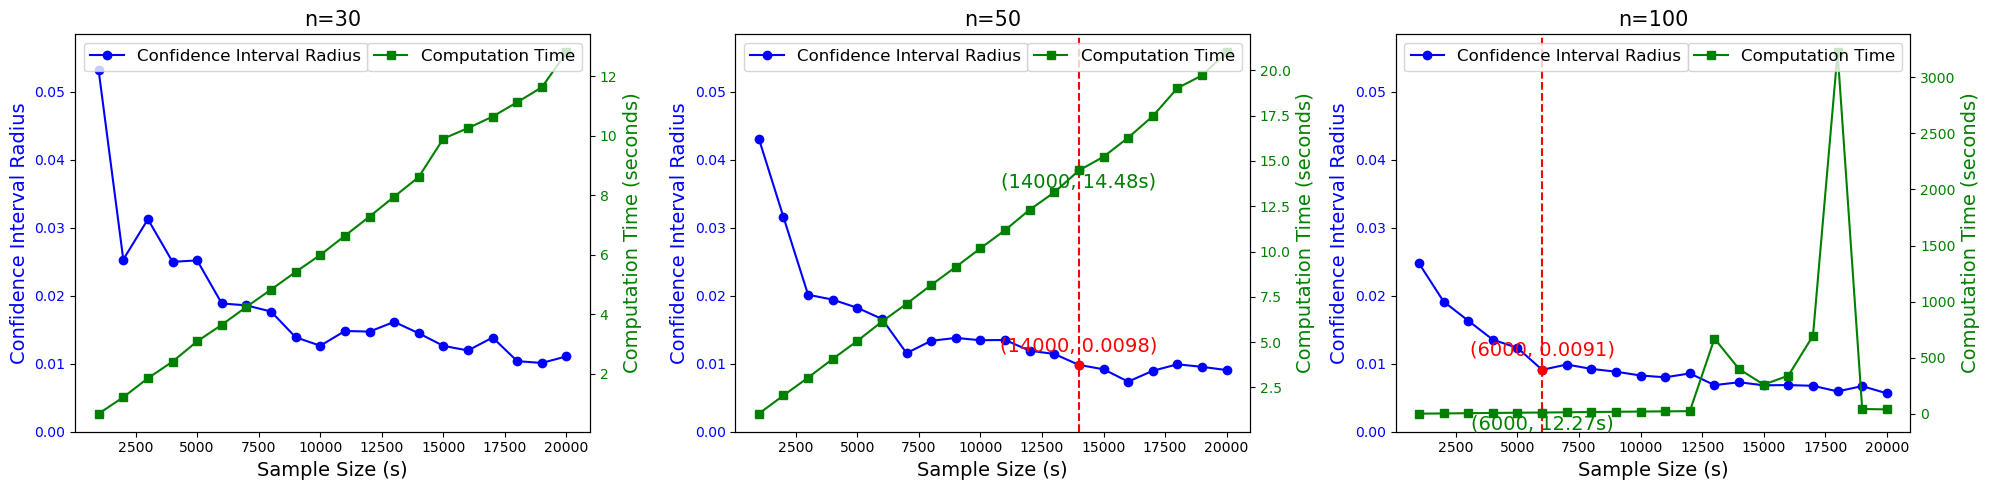

In [343]:
# Function to find the minimum sample size where the confidence interval is below the threshold
def find_min_confidence_interval_time(sample_sizes, conf_intervals, times, threshold=0.001):
    valid_indices = np.where(conf_intervals < threshold)[0]
    if valid_indices.size == 0:
        print("No sample size meets the criterion.")
        return None, None, None  # Return None if no valid index found

    for idx in valid_indices:
        if all(conf_intervals[idx:] < threshold):
            min_s_index = idx
            break
    else:  # If no break occurred in the loop
        return None, None, None

    min_s = sample_sizes[min_s_index]
    min_conf_interval = conf_intervals[min_s_index]
    min_time = times[min_s_index]
    return min_s, min_conf_interval, min_time

# Modified function to mark minimum confidence interval time on the plots
def mark_min_confidence_interval_time(ax, ax2, sample_sizes, conf_intervals, times, threshold, notationcolorx='r', notationcolory='g'):
    min_s, min_conf_interval, min_time = find_min_confidence_interval_time(sample_sizes, conf_intervals, times, threshold)

    if min_s is None:
        return

    # Mark and annotate the point on the confidence interval plot
    ax.plot(min_s, min_conf_interval, 'o', color=notationcolorx)
    ax.annotate(f'({min_s}, {min_conf_interval:.4f})', (min_s, min_conf_interval),
                textcoords="offset points", xytext=(0,10), ha='center', color=notationcolorx, fontsize=14)

    # Draw a vertical line on the plot for minimum sample size
    ax.axvline(x=min_s, color=notationcolorx, linestyle='--')

    # Mark and annotate the point on the computation time plot
    ax2.plot(min_s, min_time, 'o', color=notationcolory)
    ax2.annotate(f'({min_s}, {min_time:.2f}s)', (min_s, min_time),
                 textcoords="offset points", xytext=(0,-12), ha='center', color=notationcolory, fontsize=14)

# Sample sizes and threshold for marking
sample_sizes = np.arange(1000, 20001, 1000)
threshold = 0.01

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plotting the results
for i, (n_val, ax) in enumerate(zip([30, 50, 100], axs)):
    # Extract the results for the current n_val
    results = results_dict[n_val]
    conf_intervals = results['conf_intervals']
    times = results['times']

    # Create secondary axis for computation time
    ax2 = ax.twinx()

    # Plot confidence interval radius and computation time
    ax.plot(sample_sizes, conf_intervals, 'o-', label='Confidence Interval Radius', color='blue')
    ax2.plot(sample_sizes, times, 's-', label='Computation Time', color='green')

    # Mark the minimum confidence interval time
    mark_min_confidence_interval_time(ax, ax2, sample_sizes, conf_intervals, times, threshold)

    # Set titles and labels
    ax.set_title(f'n={n_val}', fontsize=15)
    ax.set_xlabel('Sample Size (s)', fontsize=14)
    ax.set_ylabel('Confidence Interval Radius', color='blue', fontsize=14)
    ax2.set_ylabel('Computation Time (seconds)', color='green', fontsize=14)
    ax.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='green')

    # Set the same y-axis limits for confidence interval radius across all subplots for comparison
    ax.set_ylim(0, max([max(res['conf_intervals']) for res in results_dict.values()]) * 1.1)

    
    ax.legend(loc='upper left', fontsize=12)
    ax2.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig("2.11 n_varies.jpg", dpi = 300)
plt.show()

## Question 3: Use other sampling methods and run comparative analysis

In [5]:
def latin_hypercube_sampling(num_samples, real_range, imag_range):
    # Create a Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d = 2)  # We have two dimensions: real and imaginary
    sample = sampler.random(n = num_samples)
    # Scale the sample to the specified ranges
    real_samples = qmc.scale(sample[:, [0]], real_range[0], real_range[1])
    imag_samples = qmc.scale(sample[:, [1]], imag_range[0], imag_range[1])
    # Combine real and imaginary parts into a 1D array of complex numbers
    complex_samples = real_samples.flatten() + 1j * imag_samples.flatten()
    return complex_samples

def orthogonal_sampling(num_samples, real_range, imag_range):
    # Create an Orthogonal Sampler
    sampler = qmc.LatinHypercube(d = 2, strength = 2)
    sample = sampler.random(n = num_samples)
    # Scale the sample to the specified ranges
    real_samples = qmc.scale(sample[:, [0]], real_range[0], real_range[1])
    imag_samples = qmc.scale(sample[:, [1]], imag_range[0], imag_range[1])
    # Combine real and imaginary parts into a 1D array of complex numbers
    complex_samples = real_samples.flatten() + 1j * imag_samples.flatten()
    return complex_samples

def sieve_of_eratosthenes(n):
    """Return an array of prime numbers up to n."""
    sieve = np.ones(n + 1, dtype=bool)
    sieve[:2] = False  # 0 and 1 are not prime numbers
    for i in range(2, int(n ** 0.5) + 1):
        if sieve[i]:
            sieve[i*i:n+1:i] = False
    return np.nonzero(sieve)[0]


#### Plot the confidence interval of these 3 sampling methods. Compare the convergence.

In [10]:
# Generate a large enough array of prime numbers since orthogonal_sampling only takes prime number's square as sample size
base_numbers = sieve_of_eratosthenes(110)[9:-1]  # Adjust the number here based on how many primes you need.107th prime number = 
# Square each number to get the sample sizes
sample_sizes = base_numbers**2

# Example usage with pure_random_sampling as the sampling method
real_range = [-2, 1]
imag_range = [-1.5, 1.5]
# Calculate the total area of the complex plane region being considered 
total_area = (real_range[1] - real_range[0]) * (imag_range[1] - imag_range[0])
n = 100  # number of times to sample for each sample size

# Calculate confidence intervals and mean areas for each sampling method
conf_intervals_random, mean_areas_random, times_pure_random = calculate_confidence_intervals(
    pure_random_sampling, sample_sizes, real_range, imag_range, n, max_iter
)

conf_intervals_latin, mean_areas_latin, times_latin = calculate_confidence_intervals(
    latin_hypercube_sampling, sample_sizes, real_range, imag_range, n, max_iter
)

conf_intervals_orthogonal, mean_areas_orthogonal, times_orthogonal = calculate_confidence_intervals(
    orthogonal_sampling, sample_sizes, real_range, imag_range, n, max_iter
)

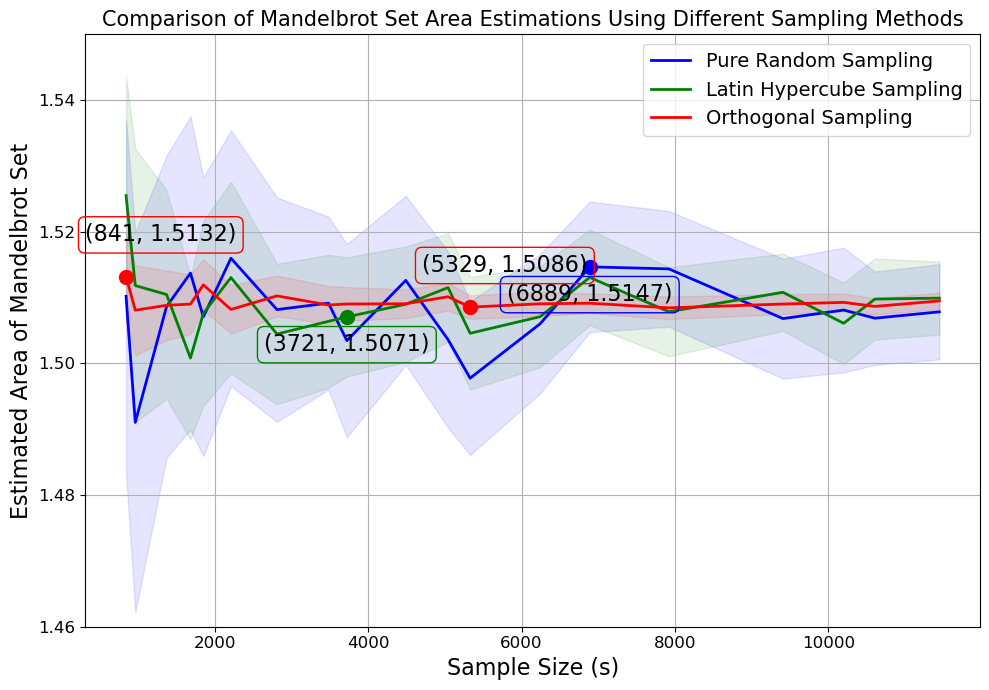

In [17]:

# Assuming the arrays 'sample_sizes', 'mean_areas_random', 'conf_intervals_random', 
# 'mean_areas_latin', 'conf_intervals_latin', 'mean_areas_orthogonal', and 'conf_intervals_orthogonal'
# are defined somewhere above this code snippet

def find_min_confidence_interval_mean(sample_sizes, conf_intervals, mean_areas, threshold=0.001):
    valid_indices = np.where(conf_intervals < threshold)[0]
    if valid_indices.size == 0:
        return None, None  # Return None if no valid index found
    for idx in valid_indices:
        if all(conf_intervals[idx:] < threshold):
            return sample_sizes[idx], mean_areas[idx]
    return None, None

def mark_point(ax, x, y, color='r', text_offset=(0, 0)):
    ax.plot(x, y, 'o', color=color, markersize=10)
    ax.annotate(f'({x}, {y:.4f})', 
                xy=(x, y), 
                xytext=text_offset,
                textcoords="offset points",
                fontsize=16,
                ha='center',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='none'))

# Define thresholds
thresholds = [0.01, 0.002]

# Create the plot
plt.figure(figsize=(10, 7))

# Plot for Pure Random Sampling
plt.plot(sample_sizes, mean_areas_random, label='Pure Random Sampling', color='blue', linewidth=2)
plt.fill_between(sample_sizes, mean_areas_random - conf_intervals_random, mean_areas_random + conf_intervals_random,
                 color='blue', alpha=0.1)

# Plot for Latin Hypercube Sampling
plt.plot(sample_sizes, mean_areas_latin, label='Latin Hypercube Sampling', color='green', linewidth=2)
plt.fill_between(sample_sizes, mean_areas_latin - conf_intervals_latin, mean_areas_latin + conf_intervals_latin,
                color='green', alpha=0.1)

# Plot for Orthogonal Sampling
plt.plot(sample_sizes, mean_areas_orthogonal, label='Orthogonal Sampling', color='red', linewidth=2)
plt.fill_between(sample_sizes, mean_areas_orthogonal - conf_intervals_orthogonal, mean_areas_orthogonal + conf_intervals_orthogonal,
                color='red', alpha=0.1)
# Plot the confidence intervals for each sampling method
for threshold in thresholds:
    min_s_random, min_mean_random = find_min_confidence_interval_mean(sample_sizes, conf_intervals_random, mean_areas_random, threshold)
    min_s_latin, min_mean_latin = find_min_confidence_interval_mean(sample_sizes, conf_intervals_latin, mean_areas_latin, threshold)
    min_s_orthogonal, min_mean_orthogonal = find_min_confidence_interval_mean(sample_sizes, conf_intervals_orthogonal, mean_areas_orthogonal, threshold)

    # Check if the points were found and then annotate them on the plot
    if min_s_random is not None:
        mark_point(plt, min_s_random, min_mean_random, color='blue', text_offset=(0, -20))
    if min_s_latin is not None:
        mark_point(plt, min_s_latin, min_mean_latin, color='green', text_offset=(0, -20))
    if min_s_orthogonal is not None:
        mark_point(plt, min_s_orthogonal, min_mean_orthogonal, color='red', text_offset=(25, 30))

# Set chart title and labels
plt.title('Comparison of Mandelbrot Set Area Estimations Using Different Sampling Methods', fontsize=15)
plt.xlabel('Sample Size (s)', fontsize=16)
plt.ylabel('Estimated Area of Mandelbrot Set', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(1.46, 1.55)
plt.tight_layout()
plt.savefig("3.1_Ais_complete.jpg", dpi=300)
plt.show()




No sample size meets the criterion.
No sample size meets the criterion.


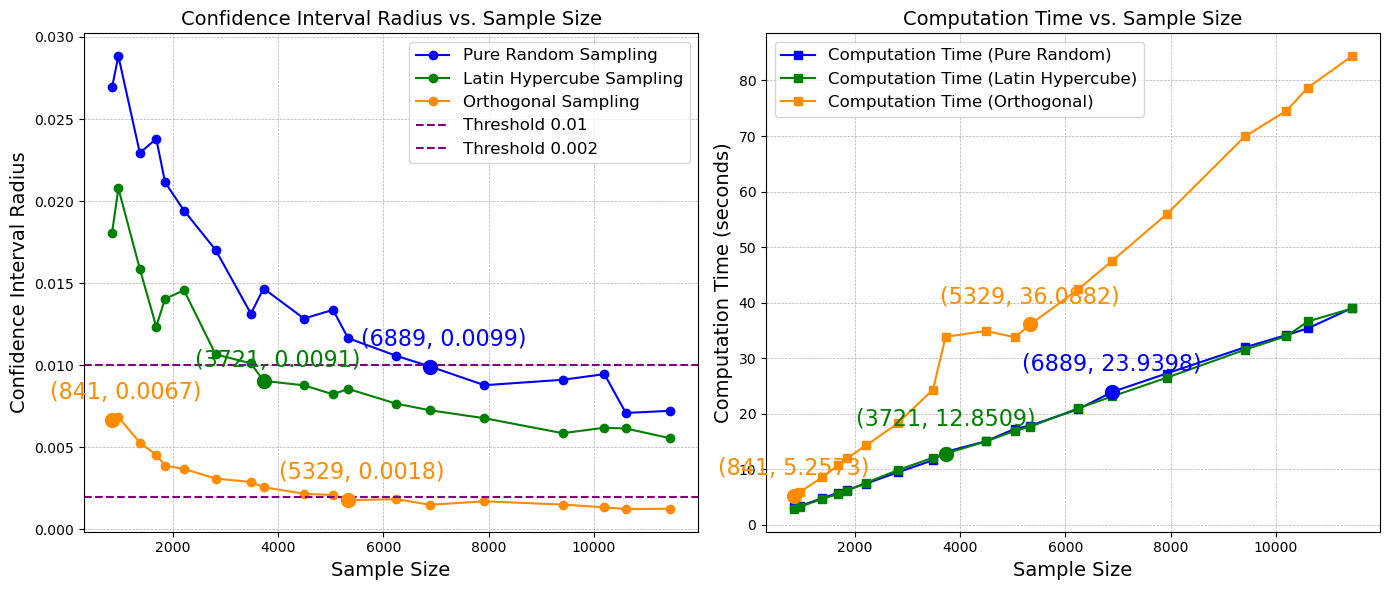

In [14]:
def find_min_confidence_interval_time(sample_sizes, conf_intervals, times, threshold=0.001):
    valid_indices = np.where(conf_intervals < threshold)[0]
    if valid_indices.size == 0:
        print("No sample size meets the criterion.")
        return None, None, None  # Return None if no valid index found

    for idx in valid_indices:
        if all(conf_intervals[idx:] < threshold):
            min_s_index = idx
            break
    else:  # If no break occurred in the loop
        return None, None, None

    min_s = sample_sizes[min_s_index]
    min_conf_interval = conf_intervals[min_s_index]
    min_time = times[min_s_index]
    return min_s, min_conf_interval, min_time

def mark_point(ax, x, y, color='r', label=None, text_offset=(0,10)):
    ax.plot(x, y, 'o', color=color, markersize=10)
    ax.annotate(f'({x}, {y:.4f})', 
                (x, y), 
                textcoords="offset points", 
                xytext=text_offset, 
                fontsize=16,
                ha='center',
                color=color)

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))  # ax2 will be used for times

# Define the thresholds
thresholds = [0.01, 0.002]

# Plot the confidence intervals for each sampling method on ax1
ax1.plot(sample_sizes, conf_intervals_random, marker='o', label='Pure Random Sampling', color='blue')
ax1.plot(sample_sizes, conf_intervals_latin, marker='o', label='Latin Hypercube Sampling', color='green')
ax1.plot(sample_sizes, conf_intervals_orthogonal, marker='o', label='Orthogonal Sampling', color='darkorange')

# Set labels and title for ax1
ax1.set_xlabel('Sample Size', fontsize=14)
ax1.set_ylabel('Confidence Interval Radius', fontsize=14)
ax1.set_title('Confidence Interval Radius vs. Sample Size', fontsize=14)

# Plot the computation times on ax2
ax2.plot(sample_sizes, times_pure_random, marker='s', label='Computation Time (Pure Random)', color='blue')
ax2.plot(sample_sizes, times_latin, marker='s', label='Computation Time (Latin Hypercube)', color='green')
ax2.plot(sample_sizes, times_orthogonal, marker='s', label='Computation Time (Orthogonal)', color='darkorange')
ax2.set_title('Computation Time vs. Sample Size', fontsize=14)

# Set labels for ax2
ax2.set_ylabel('Computation Time (seconds)', fontsize=14)
ax2.set_xlabel('Sample Size', fontsize=14)

# Plot threshold lines and find the minimum s for each threshold
for threshold in thresholds:
    ax1.axhline(y=threshold, color='red' if threshold == 0.003 else 'purple', linestyle='--', label=f'Threshold {threshold}')

    # Pure Random Sampling
    min_s_random, min_conf_interval_random, min_time_random = find_min_confidence_interval_time(
        sample_sizes, conf_intervals_random, times_pure_random, threshold
    )
    if min_s_random is not None:
        mark_point(ax1, min_s_random, min_conf_interval_random, color='blue', text_offset=(10, 15))
        mark_point(ax2, min_s_random, min_time_random, color='blue', text_offset=(0, 15))

    # Latin Hypercube Sampling
    min_s_latin, min_conf_interval_latin, min_time_latin = find_min_confidence_interval_time(
        sample_sizes, conf_intervals_latin, times_latin, threshold
    )
    if min_s_latin is not None:
        mark_point(ax1, min_s_latin, min_conf_interval_latin, color='green', text_offset=(10, 10))
        mark_point(ax2, min_s_latin, min_time_latin, color='green', text_offset=(0, 20))

    # Orthogonal Sampling
    min_s_orthogonal, min_conf_interval_orthogonal, min_time_orthogonal = find_min_confidence_interval_time(
        sample_sizes, conf_intervals_orthogonal, times_orthogonal, threshold
    )
    if min_s_orthogonal is not None:
        mark_point(ax1, min_s_orthogonal, min_conf_interval_orthogonal, color='darkorange', text_offset=(10, 15))
        mark_point(ax2, min_s_orthogonal, min_time_orthogonal, color='darkorange', text_offset=(0, 15))

# Add legends and set up the grid for both subplots
ax1.legend(loc='upper right', fontsize=12)
ax2.legend(loc='upper left', fontsize=12)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save and show the figure
plt.tight_layout()
plt.savefig("3.3_confidence_interval_and_time.png", dpi=300)
plt.show()



In [ ]:
print(conf_intervals_orthogonal)

[0.04451405 0.02824473 0.02311004 0.01424471 0.01198168 0.0085604
 0.0069296  0.00627299 0.00484542 0.00436834 0.00377767 0.00351815
 0.00278424 0.0029891  0.00246712 0.00196454 0.00203458 0.00220201
 0.00181887 0.00185083 0.00148467 0.00125045 0.00121792 0.0011724
 0.00138152 0.00115855 0.00106333 0.0008823  0.00092576 0.00086738
 0.00074521]


#### Plot the relative error using 3 methods. Compare the curve and the min s.

Now we define relative_error as Ais/Am to see how the sampling method influence the Ais.

Now we take each(i,s) combination for repetitions to simulate the variance and mean.

## Qustion 4: Formulate and test a method to further improve the convergence rate

### 4.1 Adaptive Sampling

In [3]:
max_iter = 1660

4.1.1 Initial sampling point

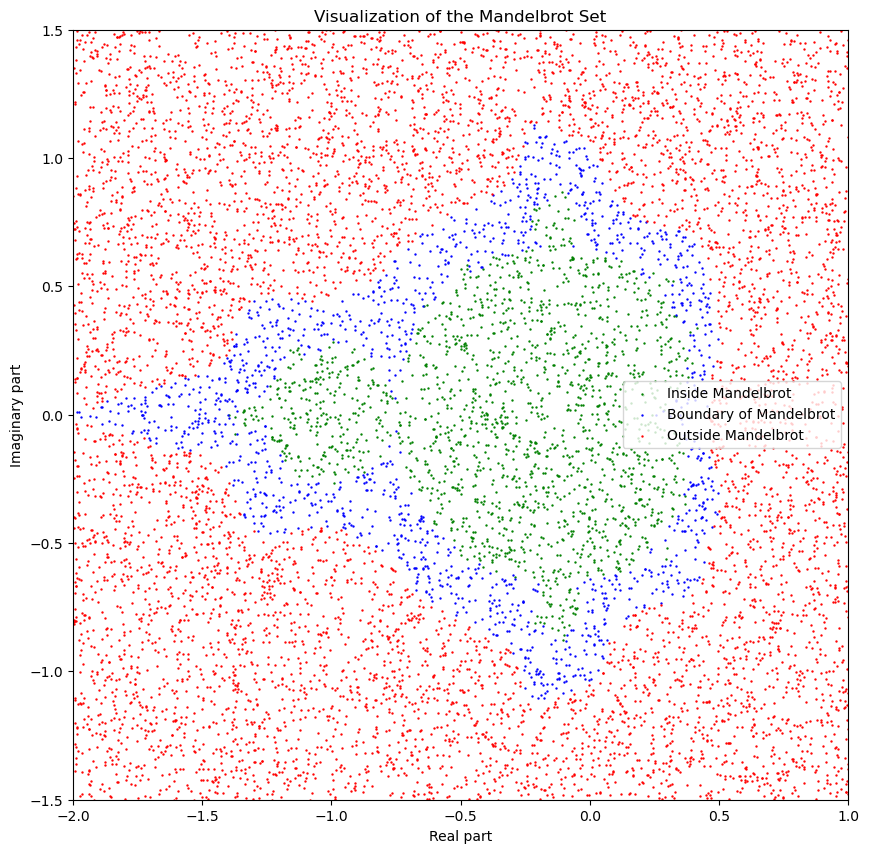

In [12]:

def mandelbrot(c, max_iter):
    z = 0
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iter

def random_sampling(x_range, y_range, num_samples):
    real = np.random.uniform(x_range[0], x_range[1], num_samples)
    imag = np.random.uniform(y_range[0], y_range[1], num_samples)
    return real + imag * 1j

def initial_sampling(x_range, y_range, num_samples, max_iter):
    points = random_sampling(x_range, y_range, num_samples)
    stabilities = [mandelbrot(c, max_iter) for c in points]
    inside_mandelbrot = [points[i] for i, stability in enumerate(stabilities) if  stability == max_iter]
    boundary_points = [points[i] for i, stability in enumerate(stabilities) if 5 < stability < max_iter]
    outside_mandelbrot = [points[i] for i, stability in enumerate(stabilities) if stability <= 5]
    return np.array(inside_mandelbrot),np.array(boundary_points),np.array(outside_mandelbrot)

x_range = [-2, 1]
y_range = [-1.5, 1.5]
num_samples = 10000

#Acquired boundary point
inside_mandelbrot, boundary_points , outside_mandelbrot= initial_sampling(x_range, y_range, num_samples, max_iter)

plt.figure(figsize=(10, 10))

# Plot each set of points with different colors
plt.scatter(inside_mandelbrot.real, inside_mandelbrot.imag, color='green', s=0.5, label='Inside Mandelbrot')
plt.scatter(boundary_points.real, boundary_points.imag, color='blue', s=0.5, label='Boundary of Mandelbrot')
plt.scatter(outside_mandelbrot.real, outside_mandelbrot.imag, color='red', s=0.5, label='Outside Mandelbrot')

plt.xlim(x_range)
plt.ylim(y_range)
plt.title('Visualization of the Mandelbrot Set')
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.legend()
plt.show()


Generate three regions

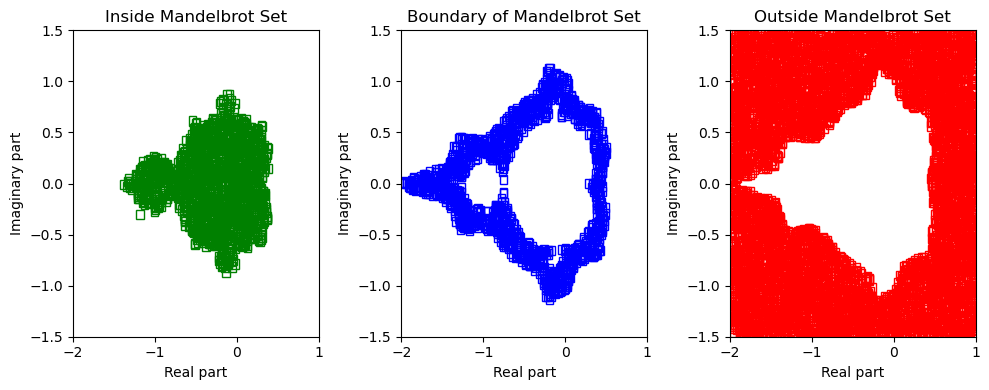

In [13]:
# Given an array of boundary points, and the size of the side length of the boundary region
def define_regions(points, side_length):
    squares = []
    half_side = side_length / 2

    for point in points:
        left = max(point.real - half_side, x_range[0])
        right = min(point.real + half_side, x_range[1])
        bottom = max(point.imag - half_side, y_range[0])
        top = min(point.imag + half_side, y_range[1])

        # Add only if the square is within the defined range
        if left < right and bottom < top:
            squares.append([left, right, bottom, top])

    return squares


init_area_of_sample = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
side_length = init_area_of_sample * 0.01
# Use examples
inside_mandelbrot, boundary_points , outside_mandelbrot = initial_sampling(x_range, y_range, num_samples, max_iter)

inside_mandelbrot_squares = define_regions(inside_mandelbrot, side_length)
boundary_squares = define_regions(boundary_points, side_length)  # 0.1 is the length of the side of the square area
outside_mandelbrot_squares = define_regions(outside_mandelbrot, side_length)

def visualize_regions(ax, squares, color, title):
    # Draw each square
    for square in squares:
        left, right, bottom, top = square
        square_patch = plt.Rectangle((left, bottom), right - left, top - bottom, 
                                     edgecolor=color, facecolor='none')
        ax.add_patch(square_patch)

    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    ax.set_title(title)

# Create a 3x1 grid of plots
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Visualize each set of regions in separate subplots
visualize_regions(axs[0], inside_mandelbrot_squares, 'green', 'Inside Mandelbrot Set')
visualize_regions(axs[1], boundary_squares, 'blue', 'Boundary of Mandelbrot Set')
visualize_regions(axs[2], outside_mandelbrot_squares, 'red', 'Outside Mandelbrot Set')

plt.tight_layout()
plt.show()

merge regions

In [14]:
x_range = [-2, 1]
y_range = [-1.5, 1.5]

# Create a rectangular polygon
rectangle = box(x_range[0], y_range[0], x_range[1], y_range[1])

# Wrap the rectangular polygon in a MultiPolygon
init_space = MultiPolygon([rectangle])

def merge_squares(squares, current_sample_space=init_space):
    # Create polygons from the list of squares
    polygons = [Polygon([(left, bottom), (right, bottom), (right, top), (left, top)]) for left, right, bottom, top in squares]
    # Merge all polygons into a single shape
    merged_area = unary_union(polygons)

    # Use intersection method to get the intersection with current_sample_space
    intersection = merged_area.intersection(current_sample_space)

    # Return the intersection as a MultiPolygon
    if isinstance(intersection, MultiPolygon):
        return intersection
    elif isinstance(intersection, Polygon):
        return MultiPolygon([intersection])
    else:
        return MultiPolygon([])  # Return an empty MultiPolygon object
    
# Compute the merged areas for each set
inside_space = merge_squares(inside_mandelbrot_squares, init_space)
boundary_space = merge_squares(boundary_squares, init_space)
outside_space = merge_squares(outside_mandelbrot_squares, init_space)

print(f"Inside Mandelbrot Set Merged Area: {inside_space.area}")
print(f"Boundary of Mandelbrot Set Merged Area: {boundary_space.area}")
print(f"Outside Mandelbrot Set Merged Area: {outside_space.area}")

print(inside_space)
print(inside_space.area + boundary_space.area + outside_space.area)


Inside Mandelbrot Set Merged Area: 1.784533224900603
Boundary of Mandelbrot Set Merged Area: 1.8436169090302181
Outside Mandelbrot Set Merged Area: 6.467303816264484
MULTIPOLYGON (((-1.1397456793724565 -0.3476054169944969, -1.2297456793724564 -0.3476054169944969, -1.2297456793724564 -0.257605416994497, -1.1397456793724565 -0.257605416994497, -1.1397456793724565 -0.3476054169944969)), ((-1.0852376232519578 -0.2434266678002431, -1.0852376232519578 -0.2537764973866002, -1.1752376232519577 -0.2537764973866002, -1.1752376232519577 -0.2324498187765163, -1.1892566266092892 -0.2324498187765163, -1.1892566266092892 -0.2027272032331873, -1.195026061675308 -0.2027272032331873, -1.195026061675308 -0.1931005228568035, -1.2527822621837585 -0.1931005228568035, -1.2527822621837585 -0.1675978392675802, -1.2587939374654398 -0.1675978392675802, -1.2587939374654398 -0.097719954562418, -1.3344146785085957 -0.097719954562418, -1.3344146785085957 -0.0864178475566072, -1.350163074977026 -0.0864178475566072, -

Process the overlapping parts and supplement the unsampled parts

In [15]:
def adjust_spaces(inside_space, boundary_space, outside_space, init_space):
    # Step 1: Add intersection with boundary_space to boundary_space
    boundary_inside_intersection = boundary_space.intersection(inside_space)
    boundary_outside_intersection = boundary_space.intersection(outside_space)
    boundary_space = boundary_space.union(boundary_inside_intersection).union(boundary_outside_intersection)

    # Step 2: Remove intersection with boundary_space from inside_space and outside_space
    inside_space = inside_space.difference(boundary_inside_intersection)
    outside_space = outside_space.difference(boundary_outside_intersection)

    # Step 3: Add intersection between inside_space and outside_space to boundary_space
    inside_outside_intersection = inside_space.intersection(outside_space)
    boundary_space = boundary_space.union(inside_outside_intersection)

    # Remove intersections from inside_space and outside_space
    inside_space = inside_space.difference(inside_outside_intersection)
    outside_space = outside_space.difference(inside_outside_intersection)

    # Step 4: Calculate the difference between the union of all spaces and init_space
    union_of_spaces = inside_space.union(boundary_space).union(outside_space)
    difference = init_space.difference(union_of_spaces)
    #difference = union_of_spaces.difference(init_space)
    # Step 5: Add the difference to boundary_space
    boundary_space = boundary_space.union(difference)
    
    return inside_space, boundary_space, outside_space

# Adjust the spaces according to the rules
adjusted_inside_space, adjusted_boundary_space, adjusted_outside_space = adjust_spaces(inside_space, boundary_space, outside_space, init_space)

# Calculate the area of adjusted spaces
adjusted_inside_area = adjusted_inside_space.area
adjusted_boundary_area = adjusted_boundary_space.area
adjusted_outside_area = adjusted_outside_space.area

print(f"Adjusted Inside Mandelbrot Set Area: {adjusted_inside_area}")
print(f"Adjusted Boundary of Mandelbrot Set Area: {adjusted_boundary_area}")
print(f"Adjusted Outside Mandelbrot Set Area: {adjusted_outside_area}")

print(adjusted_inside_space)
print(adjusted_outside_space)
print(adjusted_inside_space.area+adjusted_boundary_space.area+adjusted_outside_space.area)


Adjusted Inside Mandelbrot Set Area: 1.2394318650939427
Adjusted Boundary of Mandelbrot Set Area: 1.8472574981778176
Adjusted Outside Mandelbrot Set Area: 5.913310636728251
POLYGON ((-0.5401611235910097 0.4248305858784657, -0.5328545808548318 0.4248305858784657, -0.5328545808548318 0.4636546204859866, -0.4676525567841416 0.4636546204859866, -0.4676525567841416 0.5203311799934579, -0.4137073640548358 0.5203311799934579, -0.4137073640548358 0.5446238780447209, -0.3802321245953152 0.5446238780447209, -0.3802321245953152 0.5718176074472127, -0.3364113338336314 0.5718176074472127, -0.3364113338336314 0.5793344394192669, -0.2916822419121731 0.5793344394192669, -0.2916822419121731 0.5983958478553734, -0.2030748425822828 0.5983958478553734, -0.2030748425822828 0.6098581986754746, -0.2011906092036652 0.6098581986754746, -0.2011906092036652 0.6248022640651126, -0.1909598602075539 0.6248022640651126, -0.1909598602075539 0.6429983212091298, -0.1648818193686736 0.6429983212091298, -0.16488181936867

Visualize the results after the first round

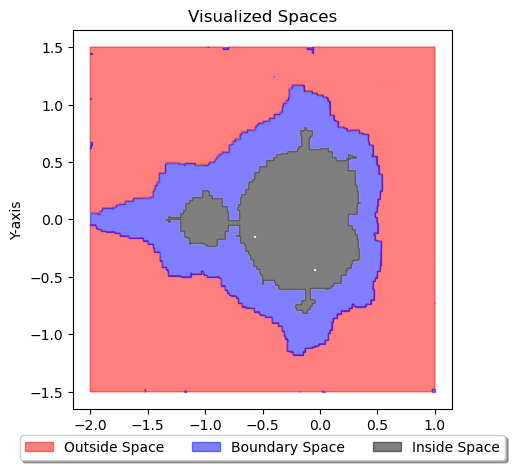

In [16]:
# Updated visualization function, allows specifying color
def visualize_space(merged_rectangles, ax, color='blue', label=''):
    # If it is a single Polygon, put it in a list
    if isinstance(merged_rectangles, Polygon):
        merged_rectangles = [merged_rectangles]
    # If it is a MultiPolygon, extract each Polygon
    elif isinstance(merged_rectangles, MultiPolygon):
        merged_rectangles = [polygon for polygon in merged_rectangles.geoms]

    # Draw and fill each polygon
    for polygon in merged_rectangles:
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=color, alpha=0.5)  # Fill the exterior polygon
        # Draw inner polygons (holes)
        for interior in polygon.interiors:
            x, y = interior.xy
            ax.fill(x, y, color='white', alpha=1)  # Fill inner polygons with white to create hole effect
    ax.fill([], [], color=color, alpha=0.5, label=label)

# Create a new plot
fig, ax = plt.subplots()

# Visualize three areas with labels for the legend
visualize_space(adjusted_outside_space, ax, color='red', label='Outside Space')    # Outer space in red
visualize_space(adjusted_boundary_space, ax, color='blue', label='Boundary Space')  # Boundary space in blue
visualize_space(adjusted_inside_space, ax, color='black', label='Inside Space')     # Inner space in black

# Set the x and y boundaries of the image
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Visualized Spaces')
plt.gca().set_aspect('equal', adjustable='box')

# Add the legend to the plot
# Place the legend outside the plot area
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3)

# Adjust the layout to make room for the legend
plt.tight_layout()

# Display the plot
plt.show()


4.1.2 Improvements in sampling methods

In [21]:
def simplify_polygon(polygon, tolerance):
    """Simplify polygons using the Douglas-Peucker algorithm"""
    return polygon.simplify(tolerance, preserve_topology=True)

def random_sampling_within_multipolygon(multipolygon, num_samples, tolerance=0.01):
    # Determine whether it is a single polygon or multiple polygons and simplify it
    polygons = [simplify_polygon(multipolygon, tolerance)] if isinstance(multipolygon, Polygon) else [simplify_polygon(p, tolerance) for p in multipolygon.geoms]

    # Determine the number of samples for each subpolygon
    total_area = sum(p.area for p in polygons)
    sample_counts = [int(p.area / total_area * num_samples) for p in polygons]

    points = []
    for polygon, num_samples_in_polygon in zip(polygons, sample_counts):
        minx, miny, maxx, maxy = polygon.bounds
        samples_in_current_polygon = 0
        while samples_in_current_polygon < num_samples_in_polygon:
            real = np.random.uniform(minx, maxx)
            imag = np.random.uniform(miny, maxy)
            point = Point(real, imag)
            if polygon.contains(point):
                complex_point = real + imag * 1j
                points.append(complex_point)
                samples_in_current_polygon += 1
    return points


#Define sampling results
def random_sampling(multipolygon, num_samples, max_iter, iteration_threshold):
    points = random_sampling_within_multipolygon(multipolygon, num_samples)
    stabilities = [mandelbrot(c, max_iter) for c in points]
    inside_mandelbrot = [points[i] for i, stability in enumerate(stabilities) if stability == max_iter]
    boundary_points = [points[i] for i, stability in enumerate(stabilities) if iteration_threshold < stability < max_iter]
    outside_mandelbrot = [points[i] for i, stability in enumerate(stabilities) if stability <= iteration_threshold]
    return np.array(inside_mandelbrot), np.array(boundary_points), np.array(outside_mandelbrot)

4.1.3 Complete Adaptive sampling function

In [22]:
def mandelbrot(c, max_iter):
    z = 0
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iter

def init_sample_area(x_range,y_range):
    # Create a rectangular polygon
    rectangle = box(x_range[0], y_range[0], x_range[1], y_range[1])

    # Wrap the rectangular polygon in a MultiPolygon
    multipolygon = MultiPolygon([rectangle])
    return multipolygon

def simplify_polygon(polygon, tolerance):
    """Simplify polygons using the Douglas-Peucker algorithm"""
    return polygon.simplify(tolerance, preserve_topology=True)

def random_sampling_within_multipolygon(multipolygon, num_samples, tolerance=0.01):
    # Determine whether it is a single polygon or multiple polygons and simplify it
    polygons = [simplify_polygon(multipolygon, tolerance)] if isinstance(multipolygon, Polygon) else [simplify_polygon(p, tolerance) for p in multipolygon.geoms]

    # Determine the number of samples for each subpolygon
    total_area = sum(p.area for p in polygons)
    sample_counts = [int(p.area / total_area * num_samples) for p in polygons]

    points = []
    for polygon, num_samples_in_polygon in zip(polygons, sample_counts):
        minx, miny, maxx, maxy = polygon.bounds
        samples_in_current_polygon = 0
        while samples_in_current_polygon < num_samples_in_polygon:
            real = np.random.uniform(minx, maxx)
            imag = np.random.uniform(miny, maxy)
            point = Point(real, imag)
            if polygon.contains(point):
                complex_point = real + imag * 1j
                points.append(complex_point)
                samples_in_current_polygon += 1
    return points

#Define sampling results
def random_sampling(multipolygon, num_samples, max_iter, iteration_threshold):
    points = random_sampling_within_multipolygon(multipolygon, num_samples)
    stabilities = [mandelbrot(c, max_iter) for c in points]
    inside_mandelbrot = [points[i] for i, stability in enumerate(stabilities) if stability == max_iter]
    boundary_points = [points[i] for i, stability in enumerate(stabilities) if iteration_threshold < stability < max_iter]
    outside_mandelbrot = [points[i] for i, stability in enumerate(stabilities) if stability <= iteration_threshold]
    return np.array(inside_mandelbrot), np.array(boundary_points), np.array(outside_mandelbrot)

#Divide the sampling results into a collection of small squares
def define_regions(points, side_length):
    squares = []
    half_side = side_length / 2

    for point in points:
        left = max(point.real - half_side, x_range[0])
        right = min(point.real + half_side, x_range[1])
        bottom = max(point.imag - half_side, y_range[0])
        top = min(point.imag + half_side, y_range[1])

        # Add only if the square is within the defined range
        if left < right and bottom < top:
            squares.append([left, right, bottom, top])

    return squares

#Convert the collection of small squares to MultiPolygon format
def merge_squares(squares, current_sample_space):
    polygons = [Polygon([(left, bottom), (right, bottom), (right, top), (left, top)]) for left, right, bottom, top in squares]
    merged_area = unary_union(polygons)

    # Use the intersection method to obtain the intersection of the merged area and current_sample_space
    intersection = merged_area.intersection(current_sample_space)

    if isinstance(intersection, MultiPolygon):
        return intersection
    elif isinstance(intersection, Polygon):
        return MultiPolygon([intersection])
    else:
        return MultiPolygon([])  # Return an empty MultiPolygon object
    
#Process the three generated MultiPolygon areas
def adjust_spaces(inside_space, boundary_space, outside_space, init_space):
    # Step 1: Add intersection with boundary_space to boundary_space
    boundary_inside_intersection = boundary_space.intersection(inside_space)
    boundary_outside_intersection = boundary_space.intersection(outside_space)
    boundary_space = boundary_space.union(boundary_inside_intersection).union(boundary_outside_intersection)

    # Step 2: Remove intersection with boundary_space from inside_space and outside_space
    inside_space = inside_space.difference(boundary_inside_intersection)
    outside_space = outside_space.difference(boundary_outside_intersection)

    # Step 3: Add intersection between inside_space and outside_space to boundary_space
    inside_outside_intersection = inside_space.intersection(outside_space)
    boundary_space = boundary_space.union(inside_outside_intersection)

    # Remove intersections from inside_space and outside_space
    inside_space = inside_space.difference(inside_outside_intersection)
    outside_space = outside_space.difference(inside_outside_intersection)

    # Step 4: Calculate the difference between the union of all spaces and init_space
    union_of_spaces = inside_space.union(boundary_space).union(outside_space)
    difference = init_space.difference(union_of_spaces)

    # Step 5: Add the difference to boundary_space
    boundary_space = boundary_space.union(difference)
    return inside_space, boundary_space, outside_space

#Perform visual drawing of each round
def visualize_space(merged_rectangles, ax, color='blue', label=''):
    # If it is a single Polygon, put it into a list
    if isinstance(merged_rectangles, Polygon):
        merged_rectangles = [merged_rectangles]
    # If it is MultiPolygon, extract each Polygon
    elif isinstance(merged_rectangles, MultiPolygon):
        merged_rectangles = [polygon for polygon in merged_rectangles.geoms]

    # Draw and fill each polygon
    for polygon in merged_rectangles:
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=color, alpha=0.5) # Fill the outer polygon
        # Draw internal polygons (holes)
        for interior in polygon.interiors:
            x, y = interior.xy
            ax.fill(x, y, color='white', alpha=1)  # Fill the inner polygons with white to create a hollow effect
    ax.fill([], [], color=color, alpha=0.5, label=label)
    
def add_area_text(fig, area, label, ypos):
    # Center the text horizontally at the given vertical position
    fig.text(0.5, ypos, f"{label}: {area:.2f}", ha='center', fontsize=9)
    
def final_sampling(multipolygon, num_samples, max_iter, iteration_threshold):
    points = random_sampling_within_multipolygon(multipolygon, num_samples)
    stabilities = [mandelbrot(c, max_iter) for c in points]

    # Count the number of points inside the Mandelbrot set
    count_inside_mandelbrot = sum(1 for stability in stabilities if stability == max_iter)

    # Calculate the probability of a point being inside the Mandelbrot set
    probability_inside_mandelbrot = count_inside_mandelbrot / num_samples
    last_area = probability_inside_mandelbrot * multipolygon.area
    return last_area


Run a complete simulation

circle 1
beta = 7
part0 code running time: 0.11157512664794922秒
part1 code running time: 0.18843722343444824秒
part2 code running time: 0.0724797248840332秒
Adjusted Inside Mandelbrot Set Area: 0.0
Adjusted Boundary of Mandelbrot Set Area: 8.235595959657868
Adjusted Outside Mandelbrot Set Area: 0.7644040403421319
Mandelbrot set 0.0


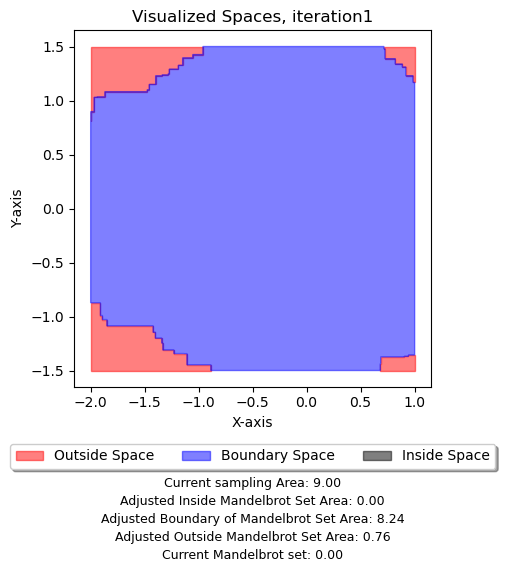

circle 2
beta = 7
part0 code running time: 0.1663062572479248秒
part1 code running time: 0.2100541591644287秒
part2 code running time: 0.10959672927856445秒
Adjusted Inside Mandelbrot Set Area: 0.0
Adjusted Boundary of Mandelbrot Set Area: 7.643227823268127
Adjusted Outside Mandelbrot Set Area: 0.5923681363897445
Mandelbrot set 0.0


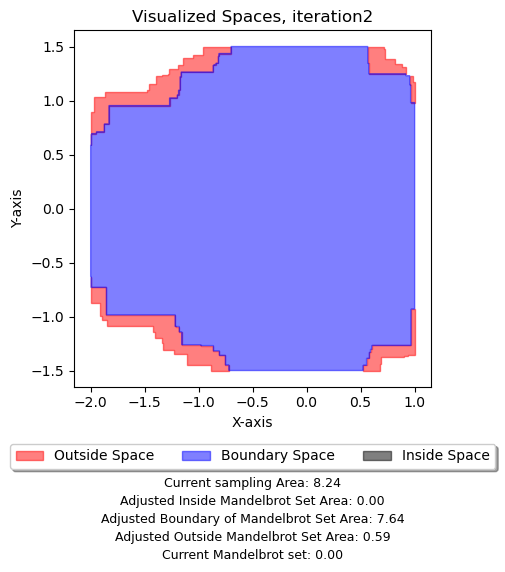

circle 3
beta = 7.700000000000001
part0 code running time: 0.18080663681030273秒
part1 code running time: 0.19436216354370117秒
part2 code running time: 0.8655767440795898秒
Adjusted Inside Mandelbrot Set Area: 0.0
Adjusted Boundary of Mandelbrot Set Area: 6.337285505025362
Adjusted Outside Mandelbrot Set Area: 1.3059423182427672
Mandelbrot set 0.0


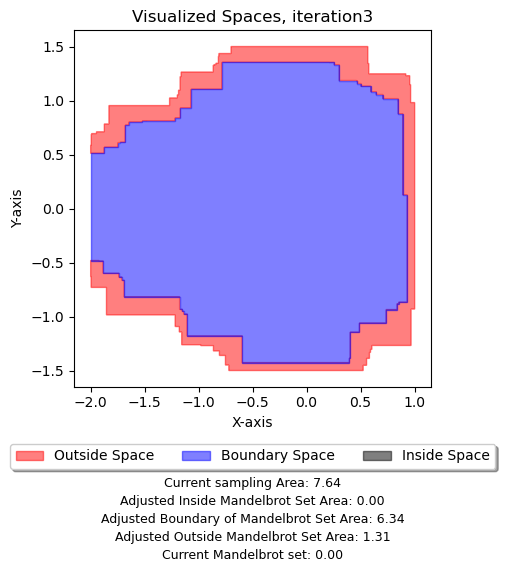

circle 4
beta = 8.470000000000002
part0 code running time: 0.22501063346862793秒
part1 code running time: 0.1318652629852295秒
part2 code running time: 0.03165483474731445秒
Adjusted Inside Mandelbrot Set Area: 0.06664620582385403
Adjusted Boundary of Mandelbrot Set Area: 4.974338215978104
Adjusted Outside Mandelbrot Set Area: 1.296301083223406
Mandelbrot set 0.06664620582385403


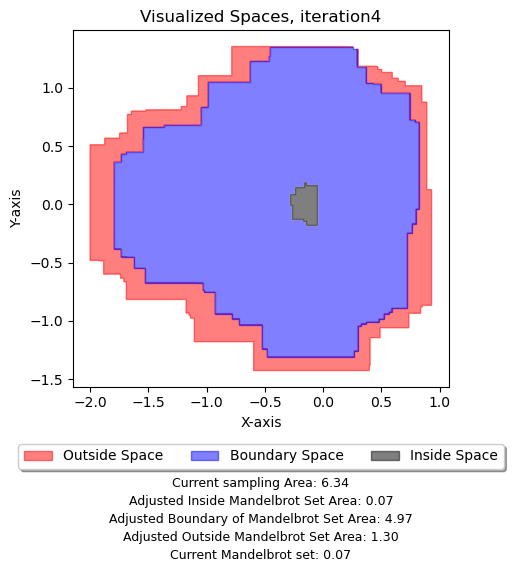

circle 5
beta = 9.317000000000004
part0 code running time: 0.31255054473876953秒
part1 code running time: 0.11169981956481934秒
part2 code running time: 0.01600360870361328秒
Adjusted Inside Mandelbrot Set Area: 0.20098813834983636
Adjusted Boundary of Mandelbrot Set Area: 3.551561392676855
Adjusted Outside Mandelbrot Set Area: 1.2217886849514135
Mandelbrot set 0.26763434417369036


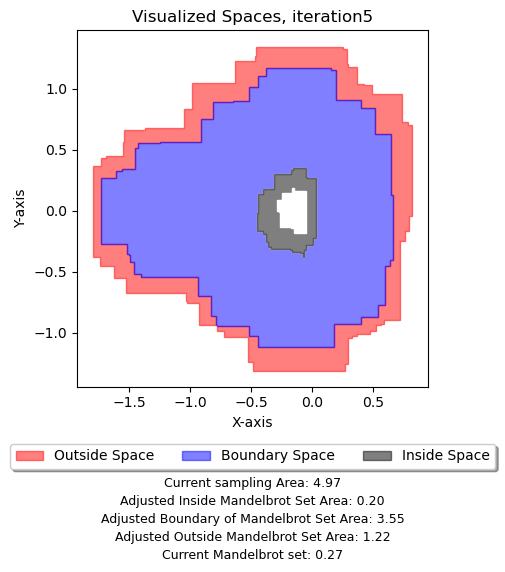

circle 6
beta = 10.248700000000005
part0 code running time: 0.33186841011047363秒
part1 code running time: 0.11118149757385254秒
part2 code running time: 0.015623092651367188秒
Adjusted Inside Mandelbrot Set Area: 0.2792834276252429
Adjusted Boundary of Mandelbrot Set Area: 2.342466014718473
Adjusted Outside Mandelbrot Set Area: 0.9298119503331383
Mandelbrot set 0.5469177717989333


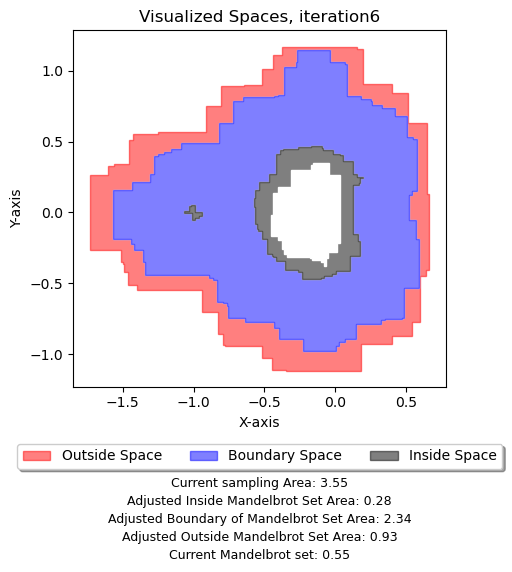

circle 7
beta = 11.273570000000007
part0 code running time: 0.4850599765777588秒
part1 code running time: 0.11667990684509277秒
part2 code running time: 0.03041219711303711秒
Adjusted Inside Mandelbrot Set Area: 0.3124501189045064
Adjusted Boundary of Mandelbrot Set Area: 1.4571373772503486
Adjusted Outside Mandelbrot Set Area: 0.5728785185636179
Mandelbrot set 0.8593678907034397


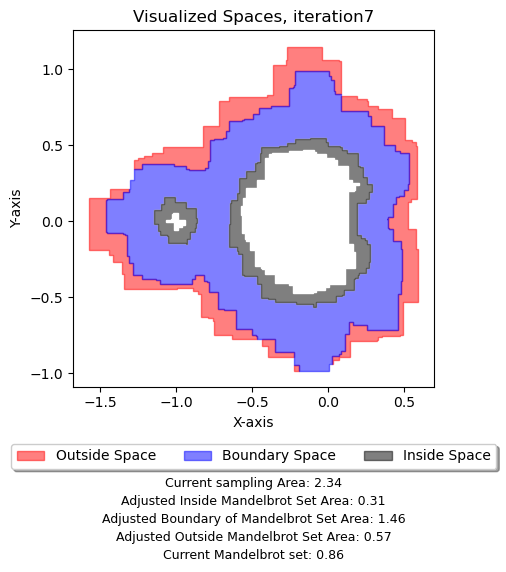

circle 8
beta = 10.146213000000007
part0 code running time: 0.653188943862915秒
part1 code running time: 0.12045454978942871秒
part2 code running time: 0.015633106231689453秒
Adjusted Inside Mandelbrot Set Area: 0.17777177325036805
Adjusted Boundary of Mandelbrot Set Area: 1.0754064271740535
Adjusted Outside Mandelbrot Set Area: 0.2039591768259292
Mandelbrot set 1.0371396639538077


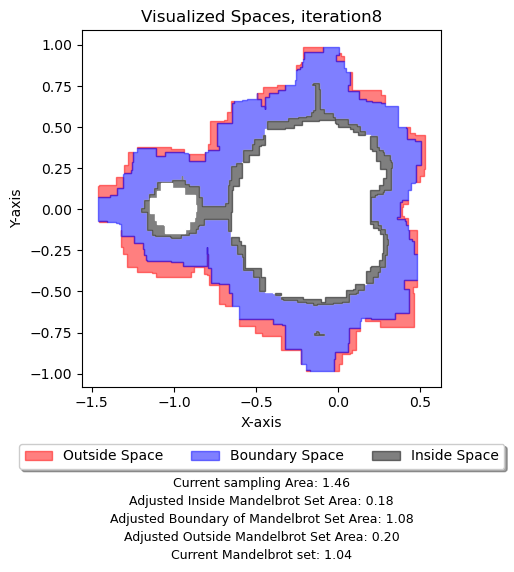

circle 9
beta = 11.160834300000008
part0 code running time: 0.8536508083343506秒
part1 code running time: 0.12664484977722168秒
part2 code running time: 0.03959465026855469秒
Adjusted Inside Mandelbrot Set Area: 0.1557076595636918
Adjusted Boundary of Mandelbrot Set Area: 0.7222362781044901
Adjusted Outside Mandelbrot Set Area: 0.19746248950587003
Mandelbrot set 1.1928473235174994


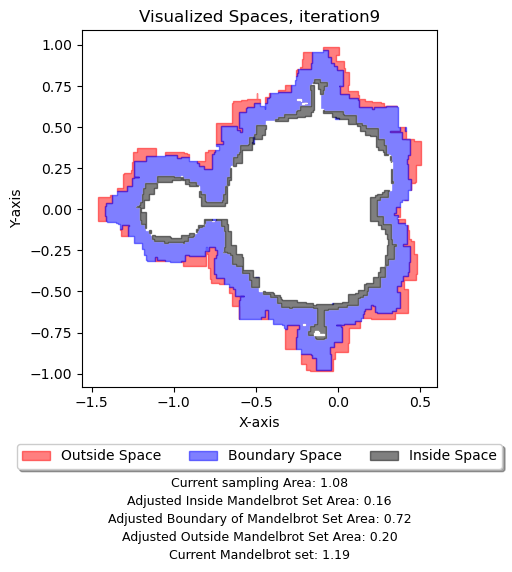

circle 10
beta = 10.044750870000009
part0 code running time: 1.4814162254333496秒
part1 code running time: 0.1394205093383789秒
part2 code running time: 0.07068133354187012秒
Adjusted Inside Mandelbrot Set Area: 0.0814035335306395
Adjusted Boundary of Mandelbrot Set Area: 0.5417175800109575
Adjusted Outside Mandelbrot Set Area: 0.0991151645628883
Mandelbrot set 1.274250857048139


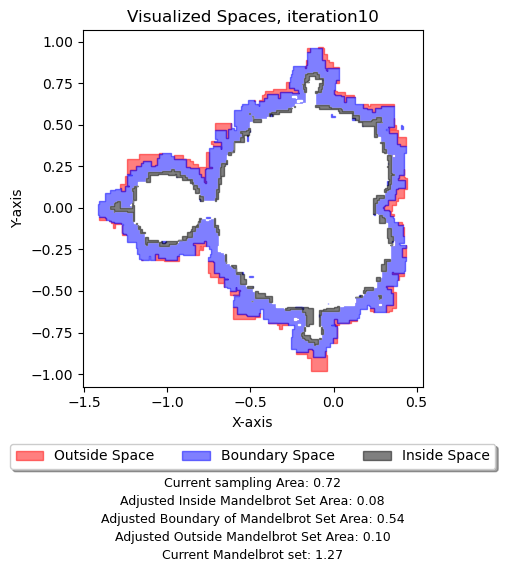

Mandelbrot set 1.5098980043529056


1.5098980043529056

In [24]:
def main():
    x_range = [-2, 1]
    y_range = [-1.5, 1.5]
    num_samples = 2000
    init_area_of_sample = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    init_space = MultiPolygon([box(x_range[0], y_range[0], x_range[1], y_range[1])])


    sampletime = 10
    aim_samplesize = []
    true_samplesize = []
    inside = []
    outside = []
    boundary = []
    beta = 7
    last_sample = 1
    unknowarea = 0

    for i in range(sampletime):
        #Continuously update border areas
        if i == 0:
            current_sample_space = init_space
            current_area_size = init_area_of_sample
        else:
            current_sample_space = adjusted_boundary_space
            current_area_size = adjusted_boundary_space.area

        aim_samplesize.append(current_sample_space)
        iteration_threshold = (i + 1) * 5
        print(f"circle {i+1}")

        if i > 1 : 
            if adjusted_inside_space.area / current_area_size <= 0.2:
                beta *= 1.1
            else:
                beta *= 0.9
        print(f"beta = {beta}")
        side_length = current_area_size / beta

        

        start_time = time.time() 
        inside_mandelbrot, boundary_points , outside_mandelbrot= random_sampling(current_sample_space, 
                                                        num_samples, max_iter, iteration_threshold)

        end_time = time.time()  
        elapsed_time = end_time - start_time  

        print(f"part0 code running time: {elapsed_time}秒")#

        start_time = time.time() 

        inside_mandelbrot_squares = define_regions(inside_mandelbrot, side_length / 1.5)
        boundary_squares = define_regions(boundary_points, side_length)  # 0.1 is the length of the side of the square area
        outside_mandelbrot_squares = define_regions(outside_mandelbrot, side_length)

        inside_space = merge_squares(inside_mandelbrot_squares, current_sample_space)
        boundary_space = merge_squares(boundary_squares, current_sample_space)
        outside_space = merge_squares(outside_mandelbrot_squares, current_sample_space)
        

        end_time = time.time() 
        elapsed_time = end_time - start_time 

        print(f"part1 code running time: {elapsed_time}秒")


        start_time = time.time()  

        adjusted_inside_space, adjusted_boundary_space, adjusted_outside_space = adjust_spaces(inside_space,
                                                            boundary_space, outside_space, current_sample_space)
        
        
        end_time = time.time() 
        elapsed_time = end_time - start_time  

        print(f"part2 code running time: {elapsed_time}秒")
        
        inside.append(adjusted_inside_space.area)
        boundary.append(adjusted_boundary_space.area)
        outside.append(adjusted_outside_space.area)
        
        print(f"Adjusted Inside Mandelbrot Set Area: {adjusted_inside_space.area}")
        print(f"Adjusted Boundary of Mandelbrot Set Area: {adjusted_boundary_space.area}")
        print(f"Adjusted Outside Mandelbrot Set Area: {adjusted_outside_space.area}")

        exact_sample_area = adjusted_inside_space.area + adjusted_boundary_space.area + adjusted_outside_space.area
        true_samplesize.append(exact_sample_area)
        print(f"Mandelbrot set {sum(inside)}")

        
        # Create a new plot with adjusted margins
        fig, ax = plt.subplots(figsize=(10, 6))  # You can adjust the figsize as needed

        # Visualize three areas with labels for the legend
        visualize_space(adjusted_outside_space, ax, color='red', label='Outside Space')    # Outer space in red
        visualize_space(adjusted_boundary_space, ax, color='blue', label='Boundary Space')  # Boundary space in blue
        visualize_space(adjusted_inside_space, ax, color='black', label='Inside Space')     # Inner space in black

        # Set the x and y boundaries of the image
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title(f"Visualized Spaces, iteration{i+1}")
        plt.gca().set_aspect('equal', adjustable='box')

        # Adjust the layout to provide space at the bottom
        fig.tight_layout(rect=[0, 0.2, 1, 0.95])  # Modify the bottom value to accommodate text

        # Place the legend at the bottom center with a custom bounding box
        legend = ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=3)

        # Adding area texts below the plot, above the legend placement
        add_area_text(fig, adjusted_inside_space.area + adjusted_boundary_space.area + adjusted_outside_space.area,
                    "Current sampling Area", 0.13)
        add_area_text(fig, adjusted_inside_space.area, "Adjusted Inside Mandelbrot Set Area", 0.10)
        add_area_text(fig, adjusted_boundary_space.area, "Adjusted Boundary of Mandelbrot Set Area", 0.07)
        add_area_text(fig, adjusted_outside_space.area, "Adjusted Outside Mandelbrot Set Area", 0.04)
        add_area_text(fig, sum(inside), "Current Mandelbrot set", 0.01)

        # Display the plot
        plt.show()
        
        if adjusted_boundary_space.area <= 0.001:
            last_sample = 1
            break
        unknowarea = adjusted_boundary_space
    if last_sample == 1:
        inside.append(final_sampling(unknowarea, num_samples, max_iter, iteration_threshold))
        print(f"Mandelbrot set {sum(inside)}")
    else:
        print(f"Mandelbrot set {sum(inside)}")
    return sum(inside)
main()

4.1.4 Adjust parameters to generate 30 simulation statistics

Remove all output parts in the main() function

In [25]:
def main():
    x_range = [-2, 1]
    y_range = [-1.5, 1.5]
    num_samples = 1000
    init_area_of_sample = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    init_space = MultiPolygon([box(x_range[0], y_range[0], x_range[1], y_range[1])])


    sampletime = 10
    aim_samplesize = []
    true_samplesize = []
    inside = []
    outside = []
    boundary = []
    beta = 7
    last_sample = 1
    unknowarea = 0

    for i in range(sampletime):
        #Continuously update border areas
        if i == 0:
            current_sample_space = init_space
            current_area_size = init_area_of_sample
        else:
            current_sample_space = adjusted_boundary_space
            current_area_size = adjusted_boundary_space.area

        aim_samplesize.append(current_sample_space)
        iteration_threshold = (i + 1) * 5

        if i > 1 : 
            if adjusted_inside_space.area / current_area_size <= 0.2:
                beta *= 1.1
            else:
                beta *= 0.9
                
        side_length = current_area_size / beta

        
        inside_mandelbrot, boundary_points , outside_mandelbrot= random_sampling(current_sample_space, 
                                                        num_samples, max_iter, iteration_threshold)


        inside_mandelbrot_squares = define_regions(inside_mandelbrot, side_length / 1.5)
        boundary_squares = define_regions(boundary_points, side_length)  # 0.1 is the length of the side of the square area
        outside_mandelbrot_squares = define_regions(outside_mandelbrot, side_length)

        inside_space = merge_squares(inside_mandelbrot_squares, current_sample_space)
        boundary_space = merge_squares(boundary_squares, current_sample_space)
        outside_space = merge_squares(outside_mandelbrot_squares, current_sample_space)

        adjusted_inside_space, adjusted_boundary_space, adjusted_outside_space = adjust_spaces(inside_space,
                                                            boundary_space, outside_space, current_sample_space)
        
        inside.append(adjusted_inside_space.area)
        boundary.append(adjusted_boundary_space.area)
        outside.append(adjusted_outside_space.area)

        exact_sample_area = adjusted_inside_space.area + adjusted_boundary_space.area + adjusted_outside_space.area
        true_samplesize.append(exact_sample_area)
        
        
        if adjusted_boundary_space.area <= 0.001:
            last_sample = 1
            break
        unknowarea = adjusted_boundary_space
    if last_sample == 1:
        inside.append(final_sampling(unknowarea, num_samples, max_iter, iteration_threshold))
        print(f"Mandelbrot set {sum(inside)}")
    else:
        print(f"Mandelbrot set {sum(inside)}")
    return sum(inside)

Calculate 99% confidence interval

In [26]:
def run_main_multiple_times(n=10):
    results = [main() for _ in range(n)]
    return results


# Run the main function 30 times
results = run_main_multiple_times(30)


Mandelbrot set 1.4785473589524885
Mandelbrot set 1.4849740868149681
Mandelbrot set 1.4887534762369694
Mandelbrot set 1.49490184865687
Mandelbrot set 1.4904328675879146
Mandelbrot set 1.4934398837374536
Mandelbrot set 1.4892175482731773
Mandelbrot set 1.4893608410907764
Mandelbrot set 1.4823508587858618
Mandelbrot set 1.488520555083288
Mandelbrot set 1.4909603781919232
Mandelbrot set 1.484153287139701
Mandelbrot set 1.4906676747457852
Mandelbrot set 1.4851679895809615
Mandelbrot set 1.4913392636942728
Mandelbrot set 1.496120773577017
Mandelbrot set 1.4948741070329161
Mandelbrot set 1.4893388360909514
Mandelbrot set 1.492545447236246
Mandelbrot set 1.4886706767675002
Mandelbrot set 1.4808168169045448
Mandelbrot set 1.4867784934381727
Mandelbrot set 1.4947111025321327
Mandelbrot set 1.4916752733144727
Mandelbrot set 1.4900807902377091
Mandelbrot set 1.47802773481775
Mandelbrot set 1.4856582717606543
Mandelbrot set 1.4977100888154342
Mandelbrot set 1.4895649934890045
Mandelbrot set 1.48739

In [28]:
def calculate_99_confidence_interval(data):
    mean = np.mean(data)
    std = np.std(data, ddof=1)  # 使用样本标准差
    se = std / np.sqrt(len(data))  # 计算标准误差
    interval = stats.norm.interval(0.99, loc=mean, scale=se)
    return interval
# 计算99%置信区间
confidence_interval = calculate_99_confidence_interval(results)
print("99% Confidence Interval:", confidence_interval)

99% Confidence Interval: (1.4865849851165025, 1.491198807297793)


### 4.2 Adaptive Sampling Optimization

#### 4.2.1 Initial equidistant sampling

In [29]:
def mandelbrot(c, max_iter):
    z = c
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iter
sample_size = 100
x_range = [-2, 1]
y_range = [-1.5, 1.5]

# Calculate the number of points on each side (approximate square root)
points_per_side = sample_size

# Generate uniformly distributed points within the specified range
x_values = np.linspace(x_range[0], x_range[1], points_per_side)
y_values = np.linspace(y_range[0], y_range[1], points_per_side)

# Iteratively calculate each point
results = []
for x in x_values:
    for y in y_values:
        c = complex(x, y)
        iteration = mandelbrot(c, max_iter)
        results.append((x, y, iteration))


create grid

In [30]:
# Define a structured data type to store the x range, y range and number of iterations for each point
dtype = [('x_range', float, (2,)), ('y_range', float, (2,)), ('iteration', int)]

# Create a structured array to store these values
structured_grid = np.zeros((points_per_side, points_per_side), dtype=dtype)

# Calculate the x and y range of each point and the number of iterations
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        c = complex(x, y)
        iteration = mandelbrot(c, max_iter)

        # Calculate the range of x and y
        x_range = [x_values[0] + (i/points_per_side) * (x_values[-1] - x_values[0]), 
                   x_values[0] + ((i+1)/points_per_side) * (x_values[-1] - x_values[0])]
        y_range = [y_values[0] + (j/points_per_side) * (y_values[-1] - y_values[0]), 
                   y_values[0] + ((j+1)/points_per_side) * (y_values[-1] - y_values[0])]

        # Store these values in a structured array
        structured_grid[j, i] = (x_range, y_range, iteration)


Initial sampling visualization

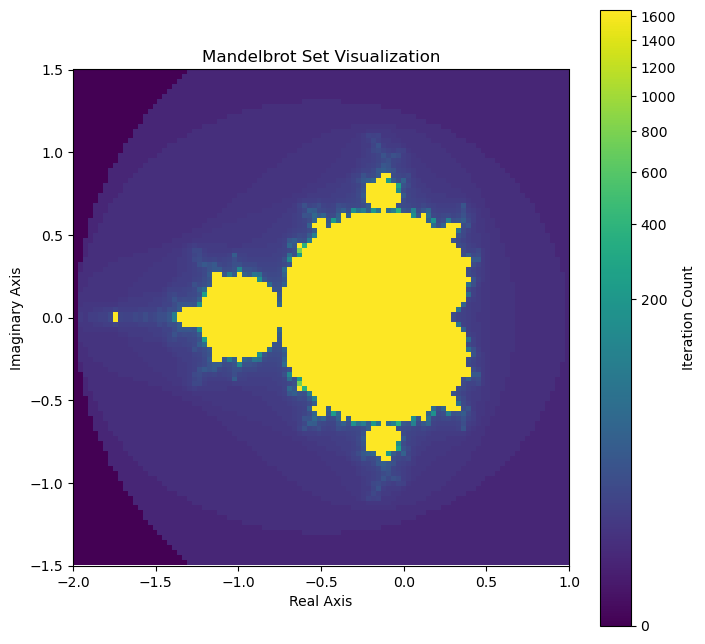

In [31]:
# Extract iteration number data for plotting
iteration_data = structured_grid['iteration']

# Create a color map where higher iterations correspond to darker colors
cmap = plt.cm.viridis
norm = mcolors.PowerNorm(0.3, vmin=iteration_data.min(), vmax=iteration_data.max())

# Draw the Mandelbrot set
plt.figure(figsize=(8, 8))
iteration_data = structured_grid['iteration']
plt.imshow(iteration_data, cmap=cmap, norm=norm, extent=[-2, 1, -1.5, 1.5])
plt.colorbar(label='Iteration Count')
plt.title('Mandelbrot Set Visualization')
plt.xlabel('Real Axis')
plt.ylabel('Imaginary Axis')
plt.show()


Basic functions in multi-run simulations

In [32]:
def create_grid(boundary_grid_list,sample_size):
    # Define the upper limit of the total number of simulations per round    
    total_max_simulations = np.square(sample_size)

    # Calculate the maximum number of simulations for each grid
    num_points = len(boundary_grid_list)
    max_simulations_per_point = total_max_simulations // num_points

   # Find the largest square number that is no larger than max_simulations_per_point
    square_root = int(math.sqrt(max_simulations_per_point))

    # Evenly divide and simulate each grid point
    simulation_results_structured = []
    for point in boundary_grid_list:
        x_start, x_end = point['x_range']
        y_start, y_end = point['y_range']

        # Calculate the step size of x and y
        x_step = (x_end - x_start) / square_root
        y_step = (y_end - y_start) / square_root

        # Carry out simulation in each small area
        for i in range(square_root):
            for j in range(square_root):
                x = x_start + (i + 0.5) * x_step 
                y = y_start + (j + 0.5) * y_step 
                c = complex(x, y)  # Center point of small area
                iteration = mandelbrot(c, max_iter)
                x_range_small = [x, x + x_step]
                y_range_small = [y, y + y_step]
                simulation_results_structured.append((x_range_small, y_range_small, iteration))

    #Convert to numpy array
    simulation_results_array = np.array(simulation_results_structured, dtype=structured_grid.dtype)
    return simulation_results_array

def select_boundary_grid(simulation_results_array,iteration_threshold,max_iter):

    # Filter elements based on the number of iterations
    array_0_to_iteration_threshold = simulation_results_array[simulation_results_array['iteration'] < iteration_threshold]
    array_iteration_threshold_to_max_iter = simulation_results_array[(simulation_results_array['iteration'] >= iteration_threshold) & 
                                            (simulation_results_array['iteration'] < max_iter)]
    array_max_iter = simulation_results_array[simulation_results_array['iteration'] == max_iter]

    return array_0_to_iteration_threshold, array_iteration_threshold_to_max_iter, array_max_iter

def mandelbrot(c, max_iter):
    z = c
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iter

#### 4.2.2 Run a complete simulation

step 1: initial sampling

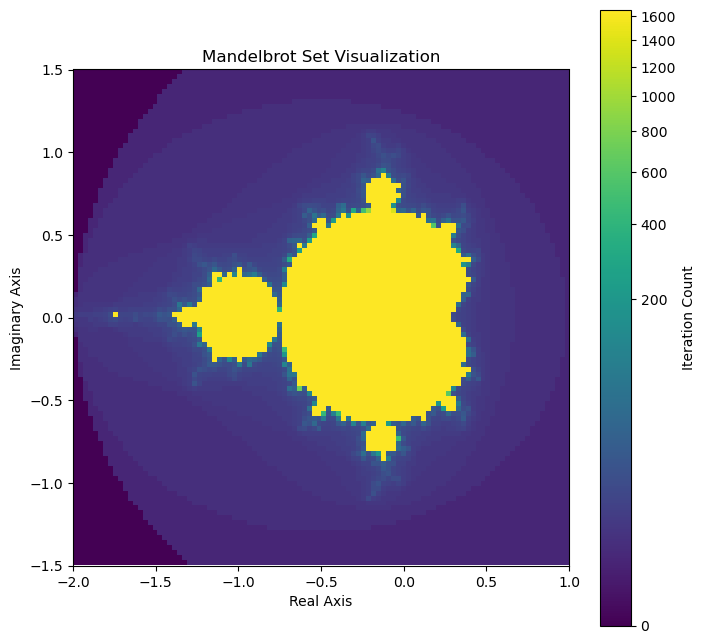

In [33]:
sample_size = 100
x_range = [-2, 1]
y_range = [-1.5, 1.5]
init_threshold = 50
in_area, bound_area, out_area = 0,0,0 
# Calculate the number of points on each side
points_per_side = sample_size

# Generate uniformly distributed points within the specified range
x_values = np.linspace(x_range[0], x_range[1], points_per_side)
y_values = np.linspace(y_range[0], y_range[1], points_per_side)

# Iteratively calculate each point
results = []
for x in x_values:
    for y in y_values:
        c = complex(x, y)
        iteration = mandelbrot(c, max_iter)
        results.append((x, y, iteration))

# Define a structured data type to store the x range, y range and number of iterations of each point
dtype = [('x_range', float, (2,)), ('y_range', float, (2,)), ('iteration', int)]

# Create a structured array to store these values
structured_grid = np.zeros((points_per_side, points_per_side), dtype=dtype)

# Calculate the x and y range of each point and the number of iterations
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        c = complex(x + (1/points_per_side/2), y + (1/points_per_side/2))
        iteration = mandelbrot(c, max_iter)

        # Calculate the range of x and y
        x_range = [x_values[0] + (i/points_per_side) * (x_values[-1] - x_values[0]), 
                   x_values[0] + ((i+1)/points_per_side) * (x_values[-1] - x_values[0])]
        y_range = [y_values[0] + (j/points_per_side) * (y_values[-1] - y_values[0]), 
                   y_values[0] + ((j+1)/points_per_side) * (y_values[-1] - y_values[0])]

        # Store these values in a structured array
        structured_grid[j, i] = (x_range, y_range, iteration)

#Initialize counter
count_less_than_threshold = 0
count_between_threshold_and_max_iter = 0
count_equal_max_iter = 0

# Traverse structured_grid to calculate the number of elements
for i in range(points_per_side):
    for j in range(points_per_side):
        iteration = structured_grid['iteration'][j, i]
        if iteration < init_threshold:
            count_less_than_threshold += 1
        elif init_threshold <= iteration < max_iter:
            count_between_threshold_and_max_iter += 1
        elif iteration == max_iter:
            count_equal_max_iter += 1

in_area += count_equal_max_iter / sample_size / sample_size * 9
out_area += count_less_than_threshold / sample_size / sample_size * 9
bound_area = count_between_threshold_and_max_iter / sample_size / sample_size * 9

# Extract iteration number data for plotting
iteration_data = structured_grid['iteration']

# Create a color map where higher iterations correspond to darker colors
cmap = plt.cm.viridis
norm = mcolors.PowerNorm(0.3, vmin=iteration_data.min(), vmax=iteration_data.max())

# Draw the Mandelbrot set
plt.figure(figsize=(8, 8))
plt.imshow(iteration_data, cmap=cmap, norm=norm, extent=[-2, 1, -1.5, 1.5])
plt.colorbar(label='Iteration Count')
plt.title('Mandelbrot Set Visualization')
plt.xlabel('Real Axis')
plt.ylabel('Imaginary Axis')
plt.show()



step 2: Adjust the boundary area to generate three types of areas

In [34]:
boundary_grid_list = []

# Collect points whose iteration number is between threshold and max_iter,
# and record their index in the original grid.
points_to_check = []
for i in range(points_per_side):
    for j in range(points_per_side):
        if init_threshold <= structured_grid['iteration'][j, i] < max_iter:
            points_to_check.append((structured_grid[j, i], i, j))  # Storage point data and index

for point, x_index, y_index in points_to_check:
    # Add initial point if it is not already in the list
    boundary_grid_list.append(point)

    # Check four adjacent grid points and add them if they are not already in the list 
    # It's okay if there are duplicate additions
    if x_index > 0:
        left_neighbor = structured_grid[y_index, x_index - 1]
        if left_neighbor['iteration'] == max_iter:
            boundary_grid_list.append(left_neighbor)
            structured_grid[y_index, x_index - 1]['iteration'] = -1

    if x_index < points_per_side - 1:
        right_neighbor = structured_grid[y_index, x_index + 1]
        if right_neighbor['iteration'] == max_iter:
            boundary_grid_list.append(right_neighbor)
            structured_grid[y_index, x_index + 1]['iteration'] = -1
    if y_index > 0:
        top_neighbor = structured_grid[y_index - 1, x_index]
        if top_neighbor['iteration'] == max_iter:
            boundary_grid_list.append(top_neighbor)
            structured_grid[y_index - 1, x_index]['iteration'] = -1
    if y_index < points_per_side - 1:
        bottom_neighbor = structured_grid[y_index + 1, x_index]
        if bottom_neighbor['iteration'] == max_iter:
            boundary_grid_list.append(bottom_neighbor)
            structured_grid[y_index + 1, x_index]['iteration'] = -1
#Convert list to numpy array
boundary_grid = np.array(boundary_grid_list, dtype=structured_grid.dtype)

in_area -= (len(boundary_grid) - len(points_to_check)) / sample_size / sample_size * 9
bound_area += (len(boundary_grid) - len(points_to_check)) / sample_size / sample_size * 9



Make an initial sampling boundary map and a grid sampling boundary map of the boundary area

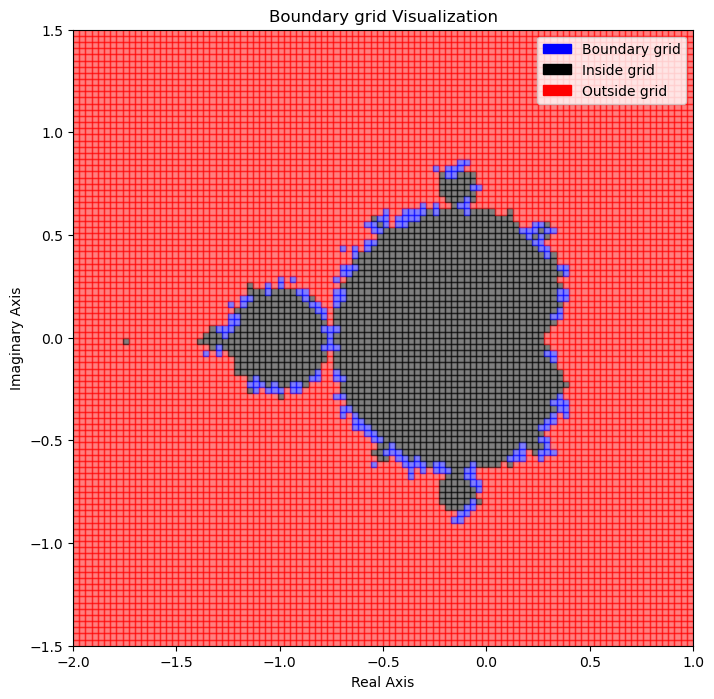

In [35]:
# Check part of the boundary_grid for plotting

points_to_add = []
for i in range(points_per_side):
    for j in range(points_per_side):
        points_to_add.append((structured_grid[j, i], i, j))  
        
Sampling_area_division_list = []
for point, x_index, y_index in points_to_add:
    Sampling_area_division_list.append(point)

Sampling_area_division = np.array(Sampling_area_division_list, dtype=structured_grid.dtype)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim([-2, 1])
ax.set_ylim([-1.5, 1.5])

labels = {'blue': 'Boundary grid', 'black': 'Inside grid', 'red': 'Outside grid'}
# Create a rectangle representing the legend
for color, label in labels.items():
    ax.add_patch(patches.Rectangle((0, 0), 0, 0, color=color, label=label))
# Traverse boundary_grid and draw rectangle
for xrange, yrange, iteration in Sampling_area_division:
    if init_threshold <= iteration < max_iter or iteration == -1:
        color = 'blue' # Define fill color here
    elif iteration == max_iter:
        color = 'black'
    else:
        color = 'red'

    # Create a rectangle and add it to the axes
    rect = patches.Rectangle((xrange[0], yrange[0]), xrange[1] - xrange[0], yrange[1] - yrange[0], color=color,alpha=0.5)
    ax.add_patch(rect)
plt.title('Boundary grid Visualization')
plt.xlabel('Real Axis')
plt.ylabel('Imaginary Axis')
ax.legend()
plt.show()

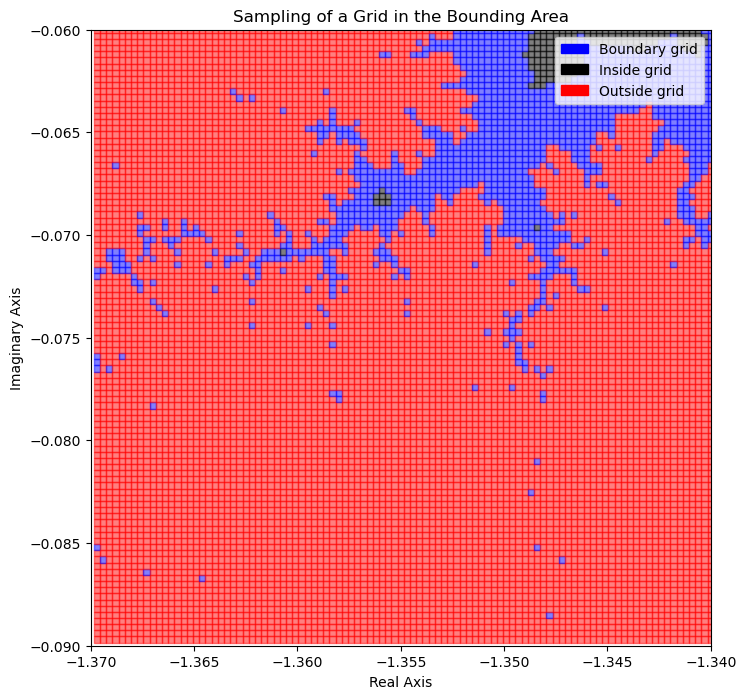

In [37]:


boundary_grid = [boundary_grid[0]]
x_range, y_range = boundary_grid[0][0], boundary_grid[0][1]
simulation_result = create_grid(boundary_grid,sample_size)
fig, ax = plt.subplots(figsize=(8, 8))

labels = {'blue': 'Boundary grid', 'black': 'Inside grid', 'red': 'Outside grid'}
# Create a rectangle representing the legend
for color, label in labels.items():
    ax.add_patch(patches.Rectangle((0, 0), 0, 0, color=color, label=label))

ax.set_xlim(x_range)
ax.set_ylim( y_range)

# Traverse boundary_grid and draw rectangle
for xrange, yrange, iteration in simulation_result:
    if init_threshold <= iteration < max_iter:
        color = 'blue'  
    elif iteration == max_iter:
        color = 'black'
    else:
        color = 'red'

    rect = patches.Rectangle((xrange[0], yrange[0]), xrange[1] - xrange[0], yrange[1] - yrange[0], color=color,alpha=0.5)
    ax.add_patch(rect)

plt.title('Sampling of a Grid in the Bounding Area')
plt.xlabel('Real Axis')
plt.ylabel('Imaginary Axis')
ax.legend(loc='upper right')
plt.show()


#### 4.2.3 Build the total simulation function

In [38]:
sample_size = 100
x_range = [-2, 1]
y_range = [-1.5, 1.5]
init_threshold = 50
in_area, bound_area, out_area = 0,0,0 
# Calculate the number of points on each side
points_per_side = sample_size

# Generate uniformly distributed points within the specified range
x_values = np.linspace(x_range[0], x_range[1], points_per_side)
y_values = np.linspace(y_range[0], y_range[1], points_per_side)

# Iteratively calculate each point
results = []
for x in x_values:
    for y in y_values:
        c = complex(x, y)
        iteration = mandelbrot(c, max_iter)
        results.append((x, y, iteration))

# Define a structured data type to store the x range, y range and number of iterations of each point
dtype = [('x_range', float, (2,)), ('y_range', float, (2,)), ('iteration', int)]

# Create a structured array to store these values
structured_grid = np.zeros((points_per_side, points_per_side), dtype=dtype)

# Calculate the x and y range of each point and the number of iterations
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        c = complex(x + (1/points_per_side/2), y + (1/points_per_side/2))
        iteration = mandelbrot(c, max_iter)

        # Calculate the range of x and y
        x_range = [x_values[0] + (i/points_per_side) * (x_values[-1] - x_values[0]), 
                   x_values[0] + ((i+1)/points_per_side) * (x_values[-1] - x_values[0])]
        y_range = [y_values[0] + (j/points_per_side) * (y_values[-1] - y_values[0]), 
                   y_values[0] + ((j+1)/points_per_side) * (y_values[-1] - y_values[0])]

        # Store these values in a structured array
        structured_grid[j, i] = (x_range, y_range, iteration)

#Initialize counter
count_less_than_threshold = 0
count_between_threshold_and_max_iter = 0
count_equal_max_iter = 0

# Traverse structured_grid to calculate the number of elements
for i in range(points_per_side):
    for j in range(points_per_side):
        iteration = structured_grid['iteration'][j, i]
        if iteration < init_threshold:
            count_less_than_threshold += 1
        elif init_threshold <= iteration < max_iter:
            count_between_threshold_and_max_iter += 1
        elif iteration == max_iter:
            count_equal_max_iter += 1

in_area += count_equal_max_iter / sample_size / sample_size * 9
out_area += count_less_than_threshold / sample_size / sample_size * 9
bound_area = count_between_threshold_and_max_iter / sample_size / sample_size * 9

boundary_grid_list = []

# Collect points whose iteration number is between threshold and max_iter,
# and record their index in the original grid.
points_to_check = []
for i in range(points_per_side):
    for j in range(points_per_side):
        if init_threshold <= structured_grid['iteration'][j, i] < max_iter:
            points_to_check.append((structured_grid[j, i], i, j))  # Storage point data and index

for point, x_index, y_index in points_to_check:
    # Add initial point if it is not already in the list
    boundary_grid_list.append(point)

    # Check four adjacent grid points and add them if they are not already in the list 
    # It's okay if there are duplicate additions
    if x_index > 0:
        left_neighbor = structured_grid[y_index, x_index - 1]
        if left_neighbor['iteration'] == max_iter:
            boundary_grid_list.append(left_neighbor)
            structured_grid[y_index, x_index - 1]['iteration'] = -1

    if x_index < points_per_side - 1:
        right_neighbor = structured_grid[y_index, x_index + 1]
        if right_neighbor['iteration'] == max_iter:
            boundary_grid_list.append(right_neighbor)
            structured_grid[y_index, x_index + 1]['iteration'] = -1
    if y_index > 0:
        top_neighbor = structured_grid[y_index - 1, x_index]
        if top_neighbor['iteration'] == max_iter:
            boundary_grid_list.append(top_neighbor)
            structured_grid[y_index - 1, x_index]['iteration'] = -1
    if y_index < points_per_side - 1:
        bottom_neighbor = structured_grid[y_index + 1, x_index]
        if bottom_neighbor['iteration'] == max_iter:
            boundary_grid_list.append(bottom_neighbor)
            structured_grid[y_index + 1, x_index]['iteration'] = -1
#Convert list to numpy array
boundary_grid = np.array(boundary_grid_list, dtype=structured_grid.dtype)

in_area -= (len(boundary_grid) - len(points_to_check)) / sample_size / sample_size * 9
bound_area += (len(boundary_grid) - len(points_to_check)) / sample_size / sample_size * 9

#Perform multiple rounds
for i in range(1,3):
    
    simulation_result = create_grid(boundary_grid,sample_size)
    total_grid = len(simulation_result)
    
    out_grid, boundary_grid, in_grid = select_boundary_grid(simulation_result,init_threshold,max_iter)
    print(f"area:{bound_area},{len(in_grid) / len(simulation_result) * bound_area},{len(boundary_grid) / len(simulation_result) * bound_area},{len(out_grid) / len(simulation_result) * bound_area}")
        
    in_area += len(in_grid) / len(simulation_result) * bound_area
    out_area += len(out_grid) / len(simulation_result) * bound_area
    bound_area = len(boundary_grid) / len(simulation_result) * bound_area

    print(f"in_area = {in_area}")
    print(f"out_area = {out_area}")
    print(f"bound_area = {bound_area}")
    print(" ")

print(f"mandelbrot set {in_area + bound_area * in_area / (in_area + out_area)}")


area:0.1881,0.126575,0.0274,0.034124999999999996
in_area = 1.499075
out_area = 7.473525
bound_area = 0.0274
 
area:0.0274,0.006347222222222222,0.013238888888888889,0.00781388888888889
in_area = 1.5054222222222222
out_area = 7.48133888888889
bound_area = 0.013238888888888889
 
mandelbrot set 1.5076399419640125


### Other things we tried to do in Q2 and Q3(all results below are not shown in the report)
- T test.
  
  For a given sample point, there are two possible states: either the point lies within the Mandelbrot set, denoted as 1, or it does not, denoted as 0. For a set of sample points, the sample mean is denoted as: 
\begin{equation}
    \bar{X} = p
\end{equation}
And the standard deviation of the sample mean is given by 
\begin{equation}
    \frac{S}{\sqrt{n}} = \sqrt{\frac{p(1-p)}{s}}
\end{equation}
The true mean is denoted by 
\begin{equation}
    \theta = \frac{A_M}{9} 
\end{equation}
where $A_M$ is defined as the biggest i and biggest s we can use(computation time acceptable) to calculate the $A_{is}$.
According to the Central Limit Theorem, the standardized variable $\frac{\bar{X} - \theta}{\sigma/\sqrt{n}}$ follows a T distribution with the freedom of s-1.
- Difine $\varepsilon$ = confidence interval raidus / mean value of samples. Study how this relative error changes when increasing s.

They are all based on we have the $A_M$ as defined by the biggest $i$ and biggest $s$ we can use(computation time acceptable) to calculate the $A_{is}$, which turns out to be not the main target for our assignment. But we did spend a lot of time on doing things above. Below we show the the T test for pure random sampling as an showcase of how much time we spent on a different thinking method(if we can difine an $A_M$).

In [ ]:
# Define a area estimation function that takes in parameters of stabiliy[]
def estimate_area_from_stabilities(stabilities, total_samples, total_area, max_iter):
    # Count the number of samples that are considered to be within the Mandelbrot set
    inside_count = sum(stability == max_iter for stability in stabilities)

    # Calculate the estimated area based on the count of inside samples and total number of samples
    estimated_area = (total_area * inside_count) / total_samples

    return estimated_area

# Define a generic function that can calculate estimations and confidence intervals using any sampling method
def calculate_estimations(sampling_method, sample_sizes, real_range, imag_range, total_area, max_iter, Am):
    estimated_areas = []
    conf_interval_radii = []
    all_stabilities = []
    p_values = []

    for s in sample_sizes:
        if s == sample_sizes[0]:
            # For the first iteration, generate all samples and calculate stabilities
            all_samples = sampling_method(s, real_range, imag_range)
            all_stabilities = [stability(c, max_iter) for c in all_samples]
        else:
            # For subsequent iterations, only generate and calculate stabilities for additional samples
            additional_samples = sampling_method(1000, real_range, imag_range)
            additional_stabilities = [stability(c, max_iter) for c in additional_samples]
            all_stabilities.extend(additional_stabilities)

        # Calculate the area using the stabilities
        area = estimate_area_from_stabilities(all_stabilities, s, total_area, max_iter)
        estimated_areas.append(area)

        # Calculate the proportion of points within the Mandelbrot set
        p = area / total_area

        # Calculate the standard error of the proportion
        se = np.sqrt((p * (1 - p)) / s)

        # Convert the standard error to an area confidence interval width
        t_score = t.ppf(0.975, df=s-1)  # t-score for 95% confidence interval
        conf_radius = t_score * se * total_area
        conf_interval_radii.append(conf_radius)
        
        # Calculate the p-value
        t_statistic = (p - Am/total_area) / (se)
        p_value = 2 * t.sf(np.abs(t_statistic), df=s-1)
        p_values.append(p_value)

    return np.array(sample_sizes), np.array(estimated_areas), np.array(conf_interval_radii), np.array(p_values)

# Function to find smallest s where p-value < 0.05 and remains so for larger sample sizes
def find_significant_points(sample_sizes, p_values):
    for i in range(len(p_values)):
        if p_values[i] < 0.05 and all(p_value < 0.05 for p_value in p_values[i:]):
            return sample_sizes[i], p_values[i]
    return None, None  # Return None if no such point is found


In [ ]:
# Example usage with pure_random_sampling as the sampling method
sample_sizes = np.arange(1000, 500001, 1000)
real_range = [-2, 1]
imag_range = [-1.5, 1.5]
# Calculate the total area of the complex plane region being considered 
total_area = (real_range[1] - real_range[0]) * (imag_range[1] - imag_range[0])

# Calculate estimations and confidence intervals
sample_sizes, estimated_areas, conf_interval_radii, p_values = calculate_estimations(
    pure_random_sampling, sample_sizes, real_range, imag_range, total_area, max_iter, Am
)

    
# Find the significant point
significant_sample_size, significant_p_value = find_significant_points(sample_sizes, p_values)


In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, p_values, label='p-value', color='red', linewidth=2)

# Add a horizontal line at p-value = 0.05
plt.axhline(y=0.05, color='blue', linestyle='--', label='Desired Level (0.05)')

# Check if a significant point was found and plot it
if significant_sample_size is not None:
    plt.plot(significant_sample_size, significant_p_value, 'o', color='purple')  # Purple dot
    plt.annotate(f'({significant_sample_size}, {significant_p_value:.2f})',
                 (significant_sample_size, significant_p_value), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=14)

plt.title('P-Value vs Sample Size', fontsize=15)
plt.xlabel('Sample Size (s)', fontsize=14)
plt.ylabel('P-Value', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks([sample_sizes[0]] + list(range(100000, sample_sizes[-1]+1, 100000)))  # Set specific x-ticks
plt.tight_layout()
plt.show()